# Project Milestone 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import unicodedata
import re
import csv
import os 
import io
#import pycld2 as cld2
import pycountry as py 
import pycountry_convert as pc 
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
# Importations of our low-level methods 
from implementations import *

In [3]:
# Ignore a recurrent error
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

---
## Importing datasets


In [4]:
current_dir = os.getcwd()
parent_folder_path = os.path.abspath(os.path.join(current_dir, ".."))
data_path = os.path.join(parent_folder_path, "data")

path_ba = data_path + '/BeerAdvocate'
path_rb = data_path + '/RateBeer'
path_mbd = data_path + '/matched_beer_data'

beers_ba = pd.read_csv(f"{path_ba}/{'beers.csv'}")
users_ba = pd.read_csv(f"{path_ba}/{'users.csv'}")
breweries_ba = pd.read_csv(f"{path_ba}/{'breweries.csv'}")

beers_rb = pd.read_csv(f"{path_rb}/{'beers.csv'}")
users_rb = pd.read_csv(f"{path_rb}/{'users.csv'}")
breweries_rb = pd.read_csv(f"{path_rb}/{'breweries.csv'}")  

ratings_mbd = pd.read_csv(f"{path_mbd}/{'ratings.csv'}", header = 1)  
beers_mbd = pd.read_csv(f"{path_mbd}/{'beers.csv'}", header = 1) 
breweries_mbd = pd.read_csv(f"{path_mbd}/{'breweries.csv'}", header = 1) 
users_mbd = pd.read_csv(f"{path_mbd}/{'users.csv'}", header = 1) 

In [5]:
# Convert Beeradvocate reviews to csv 
txt_to_csv(path_ba,"reviews")
# Convert Beeradvocate ratings to csv
txt_to_csv(path_ba,"ratings")

reviews.csv is already present in the folder
ratings.csv is already present in the folder


In [6]:
# Convert RateBeer reviews and ratings to csv
txt_to_csv(path_rb,"reviews")
txt_to_csv(path_rb,"ratings")

reviews.csv is already present in the folder
ratings.csv is already present in the folder


We can see that reviews.txt and ratings.txt extracted from RateBeer are identicals text files simply because "*on RateBeer, you are required to write at least 75 characters describing the beer, and you must give it five different numeric ratings.*" In further analysis, we will simply use ratings.txt

In [7]:
# deep copies of all dataframes 
beers_ba_f = beers_ba.copy(deep=True)
users_ba_f = users_ba.copy(deep=True)
breweries_ba_f = breweries_ba.copy(deep=True)

beers_rb_f = beers_rb.copy(deep=True)
users_rb_f = users_rb.copy(deep=True)
breweries_rb_f = breweries_rb.copy(deep=True)

ratings_mbd_f = ratings_mbd.copy(deep=True)
breweries_mbd_f = breweries_mbd.copy(deep=True)
beers_mbd_f = beers_mbd.copy(deep=True)
users_mbd_f = users_mbd.copy(deep=True)

# 1.  Data observation 

In [278]:
display(beers_ba_f.head(4))
beers_ba_f.shape

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN


(280823, 15)

In [279]:
display(beers_rb_f.head(4))
beers_rb_f.shape

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667


(442081, 14)

In [280]:
display(breweries_ba_f.head(4))
breweries_ba_f.shape

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4


(16758, 4)

In [281]:
display(breweries_rb_f.head(4))
breweries_rb_f.shape

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66


(24189, 4)

In [282]:
display(users_ba_f.head(4))
users_ba_f.shape

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland


(153704, 6)

In [283]:
display(users_rb_f.head(4))
users_rb_f.shape

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain


(70174, 5)

### Reviews.csv and Ratings.csv datasets

In [105]:
reviews_ba = pd.read_csv(f"{path_ba}/reviews.csv", nrows=100)
reviews_ba.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ..."
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....."


In [106]:
ratings_ba = pd.read_csv(f"{path_ba}/ratings.csv", nrows=100)
ratings_ba.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True


In [286]:
reviews_rb = pd.read_csv(f"{path_rb}/reviews.csv", nrows=100)
reviews_rb.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."


In [287]:
ratings_rb = pd.read_csv(f"{path_rb}/ratings.csv", nrows=100)
ratings_rb.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."


### Looking for NaN

In [288]:
beers_ba_f.isna().sum()

beer_id                           0
beer_name                         0
brewery_id                        0
brewery_name                      0
style                             0
nbr_ratings                       0
nbr_reviews                       0
avg                           32829
ba_score                     219623
bros_score                   275121
abv                           36024
avg_computed                  32841
zscore                       240538
nbr_matched_valid_ratings         0
avg_matched_valid_ratings    252551
dtype: int64

In [289]:
beers_rb_f.isna().sum()

beer_id                           0
beer_name                         0
brewery_id                        0
brewery_name                      0
style                             0
nbr_ratings                       0
overall_score                338053
style_score                  338013
avg                           46424
abv                           42094
avg_computed                  45391
zscore                       399853
nbr_matched_valid_ratings         0
avg_matched_valid_ratings    399853
dtype: int64

In [290]:
breweries_ba_f.isna().sum()

id           0
location     0
name         0
nbr_beers    0
dtype: int64

In [291]:
breweries_rb_f.isna().sum()

id           0
location     0
name         0
nbr_beers    0
dtype: int64

In [292]:
users_ba_f.isna().sum()

nbr_ratings        0
nbr_reviews        0
user_id            0
user_name          1
joined          2652
location       31279
dtype: int64

In [293]:
users_rb_f.isna().sum()

nbr_ratings        0
user_id            0
user_name          0
joined            30
location       19582
dtype: int64

### Matched beer data files 

In [294]:
print('Size of beers file: ', beers_mbd_f.shape)
print('Size of breweries file: ', breweries_mbd_f.shape)
print('Size of users file: ', users_mbd_f.shape)

Size of beers file:  (45640, 33)
Size of breweries file:  (8281, 10)
Size of users file:  (3020, 13)


Noticing the small size of the matched beer data files compared to the individual files for RateBbeer and BeerAdvocate, we decide to study the other files instead if these the matched ones. 

# 2. Basic metrics to measure the trend of a beer 

In this part we will have a look at different variables such as the number of ratings, the styles of beers, the scores, the average across all ratings. First, we will have a look at them individually and see if there are any correlations between them. Secondly, we will study them regarding the location variable. 

### Number of ratings 

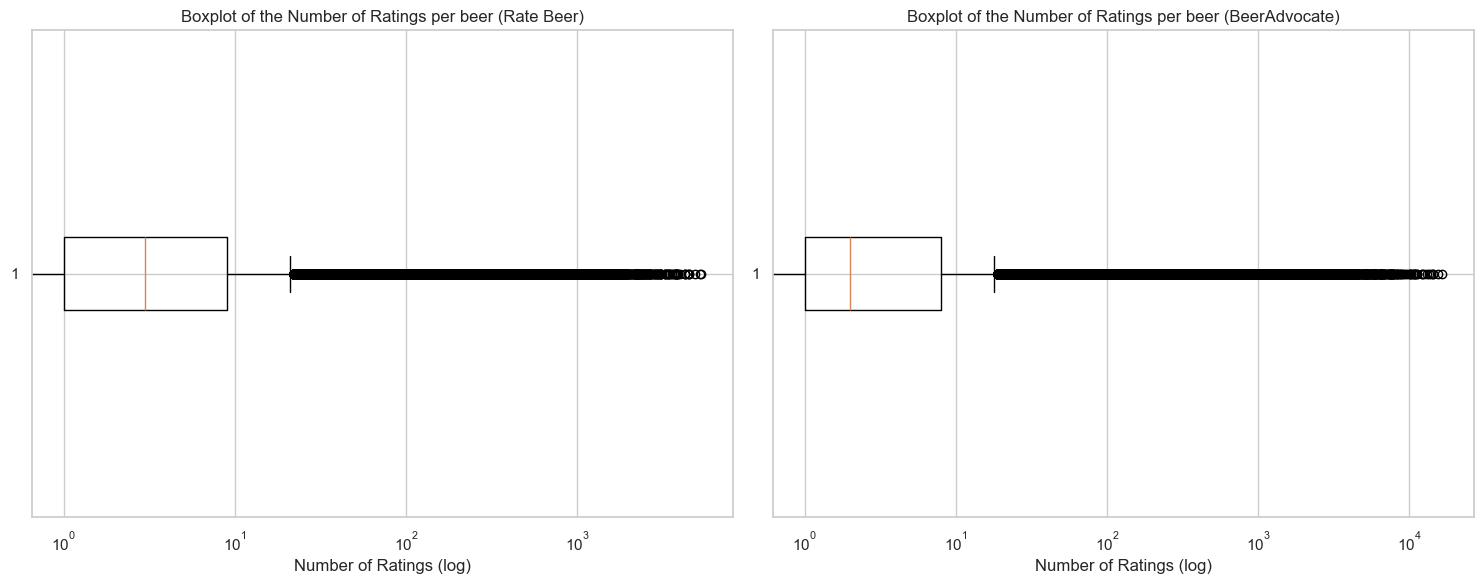

In [295]:
# Number of ratings per beer 
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.boxplot(beers_rb_f['nbr_ratings'], vert=False)
plt.title('Boxplot of the Number of Ratings per beer (Rate Beer)')
plt.xlabel('Number of Ratings (log)')
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.boxplot(beers_ba_f['nbr_ratings'], vert=False)
plt.title('Boxplot of the Number of Ratings per beer (BeerAdvocate)')
plt.xlabel('Number of Ratings (log)')
plt.xscale('log')

plt.tight_layout()
plt.show()

As we can see the mean number of ratings per beer for both sites is pretty low. However, there are a lot of beers that receives a huge number of ratings on both sites, suggesting that some beers stand out from others. 

### Styles of beer

In [107]:
# Number of styles of beers 
nbr_style_ba = beers_ba_f['style'].value_counts().nlargest(15)
nbr_style_rb = beers_rb_f['style'].value_counts().nlargest(15)
nbr_style_mbd = ratings_mbd_f['style'].value_counts().nlargest(15)

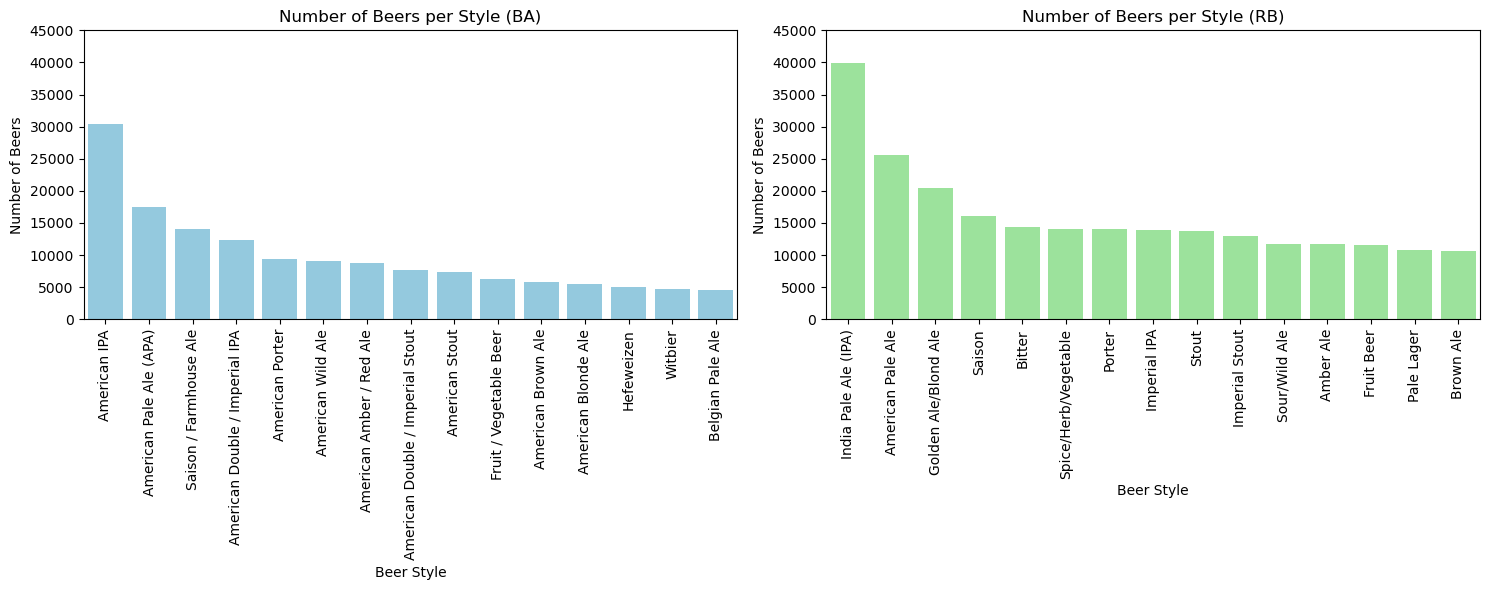

In [108]:
plt.figure(figsize=(15, 6))

# Number of styles of beers for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x=nbr_style_ba.index, y=nbr_style_ba.values, color='skyblue')
plt.title('Number of Beers per Style (BA)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

# Number of styles of beers for RateBeer
plt.subplot(1, 2, 2)
sns.barplot(x=nbr_style_rb.index, y=nbr_style_rb.values, color='lightgreen')
plt.title('Number of Beers per Style (RB)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

plt.show()

As we can see the two most represented styles on both sites are IPA beers. 

### Number of ratings per style of beer

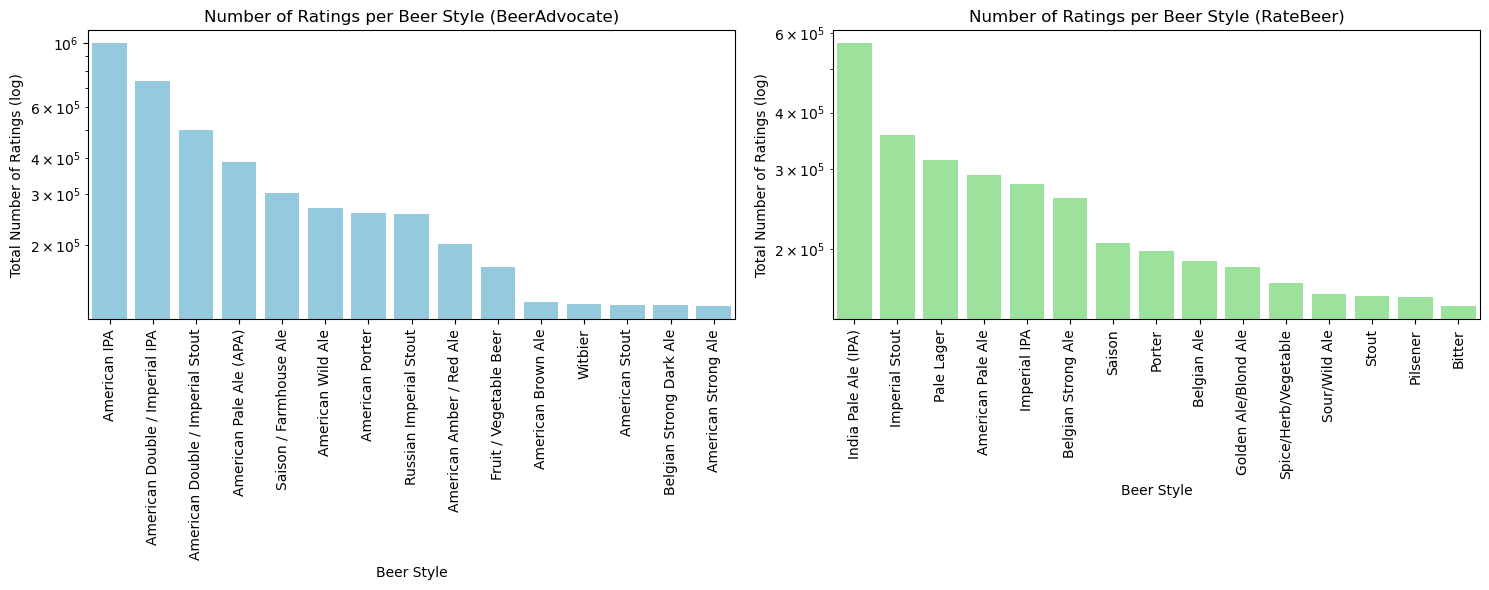

In [109]:
# Number of ratings per beer style for BeerAdvocate
ba_ratings_style = beers_ba_f[['style', 'nbr_ratings']].groupby('style').sum().reset_index()
ba_ratings_style = ba_ratings_style.sort_values(by='nbr_ratings', ascending=False)
ba_ratings_style= ba_ratings_style.nlargest(15, 'nbr_ratings') # only select the 15 most rated beers 

# Number of ratings per beer style for RateBeer
rb_ratings_style = beers_rb_f[['style', 'nbr_ratings']].groupby('style').sum().reset_index()
rb_ratings_style = rb_ratings_style.sort_values(by='nbr_ratings', ascending=False)
rb_ratings_style= rb_ratings_style.nlargest(15, 'nbr_ratings') # only select the 15 most rated beers 

plt.figure(figsize=(15, 6))

# Plot for BeerAdvocate
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=ba_ratings_style, x='style', y='nbr_ratings', color='skyblue')
plt.title('Number of Ratings per Beer Style (BeerAdvocate)')
plt.xlabel('Beer Style')
plt.ylabel('Total Number of Ratings (log)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')  

# Plot for RateBeer
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=rb_ratings_style, x='style', y='nbr_ratings', color='lightgreen')
plt.title('Number of Ratings per Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Total Number of Ratings (log)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')  

plt.show()

As we can see the most rated beer style is a type of IPA for both sites. Overall, having a first look at the style variable we can see that IPAs are greatly represented on BeerAdvocate and on RateBeer. 

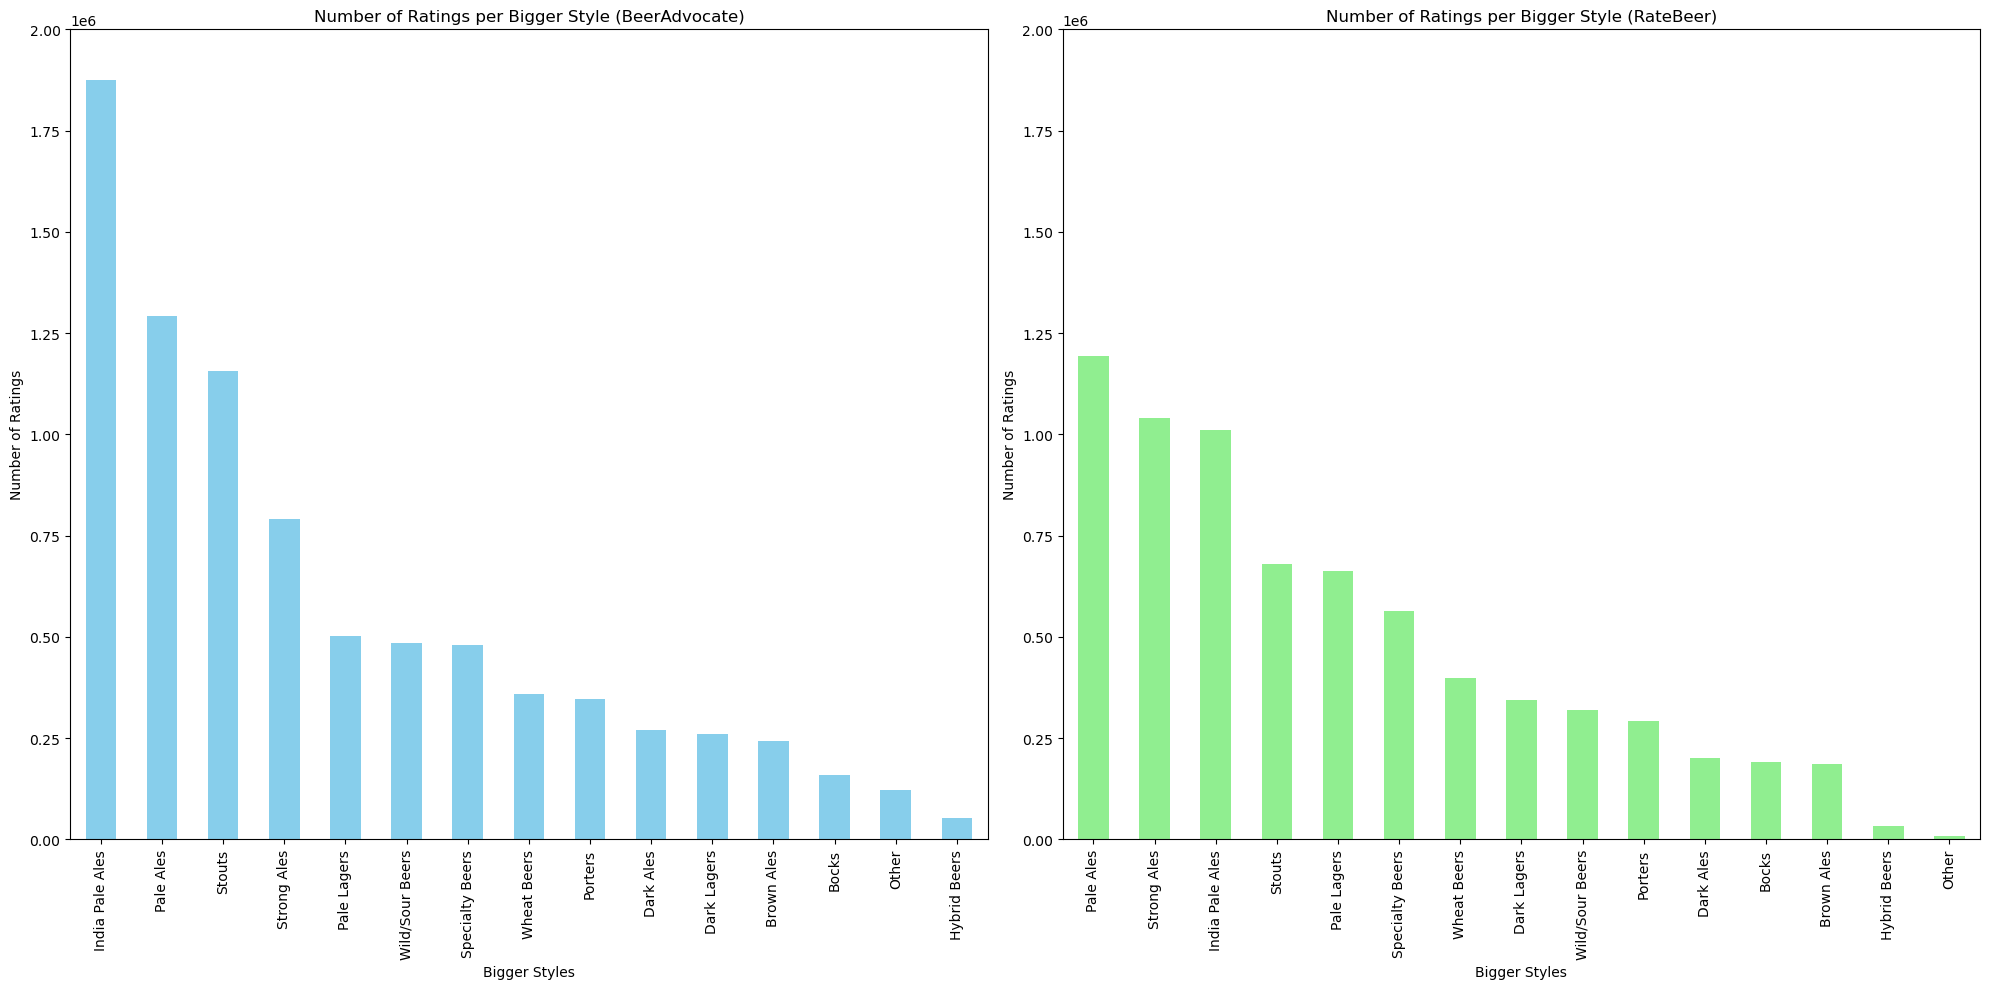

In [110]:
# Categorize each style with the Bigger styles of beer of each website 
beers_ba_f['bigger_style'] = beers_ba_f['style'].apply(categorize_style)
beers_rb_f['bigger_style'] = beers_rb_f['style'].apply(categorize_style)

ratings_per_bigger_style_ba = beers_ba_f.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)
ratings_per_bigger_style_rb = beers_rb_f.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 10))

# Plot for BeerAdvocate
plt.subplot(1,2,1)
ax1 = ratings_per_bigger_style_ba.plot(kind='bar', color='skyblue')
plt.title('Number of Ratings per Bigger Style (BeerAdvocate)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.ylim(0,2000000)
plt.xticks(rotation=90)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = ratings_per_bigger_style_rb.plot(kind='bar', color='lightgreen')
plt.title('Number of Ratings per Bigger Style (RateBeer)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.ylim(0,2000000)
plt.tight_layout()

plt.show()

Even when looking at a bigger picture, IPAs still are in the top 3 most rated beer style on both websites. Pales Ales, Stout and Strong Ales are also greatly represented on the websites. 

### Scores 

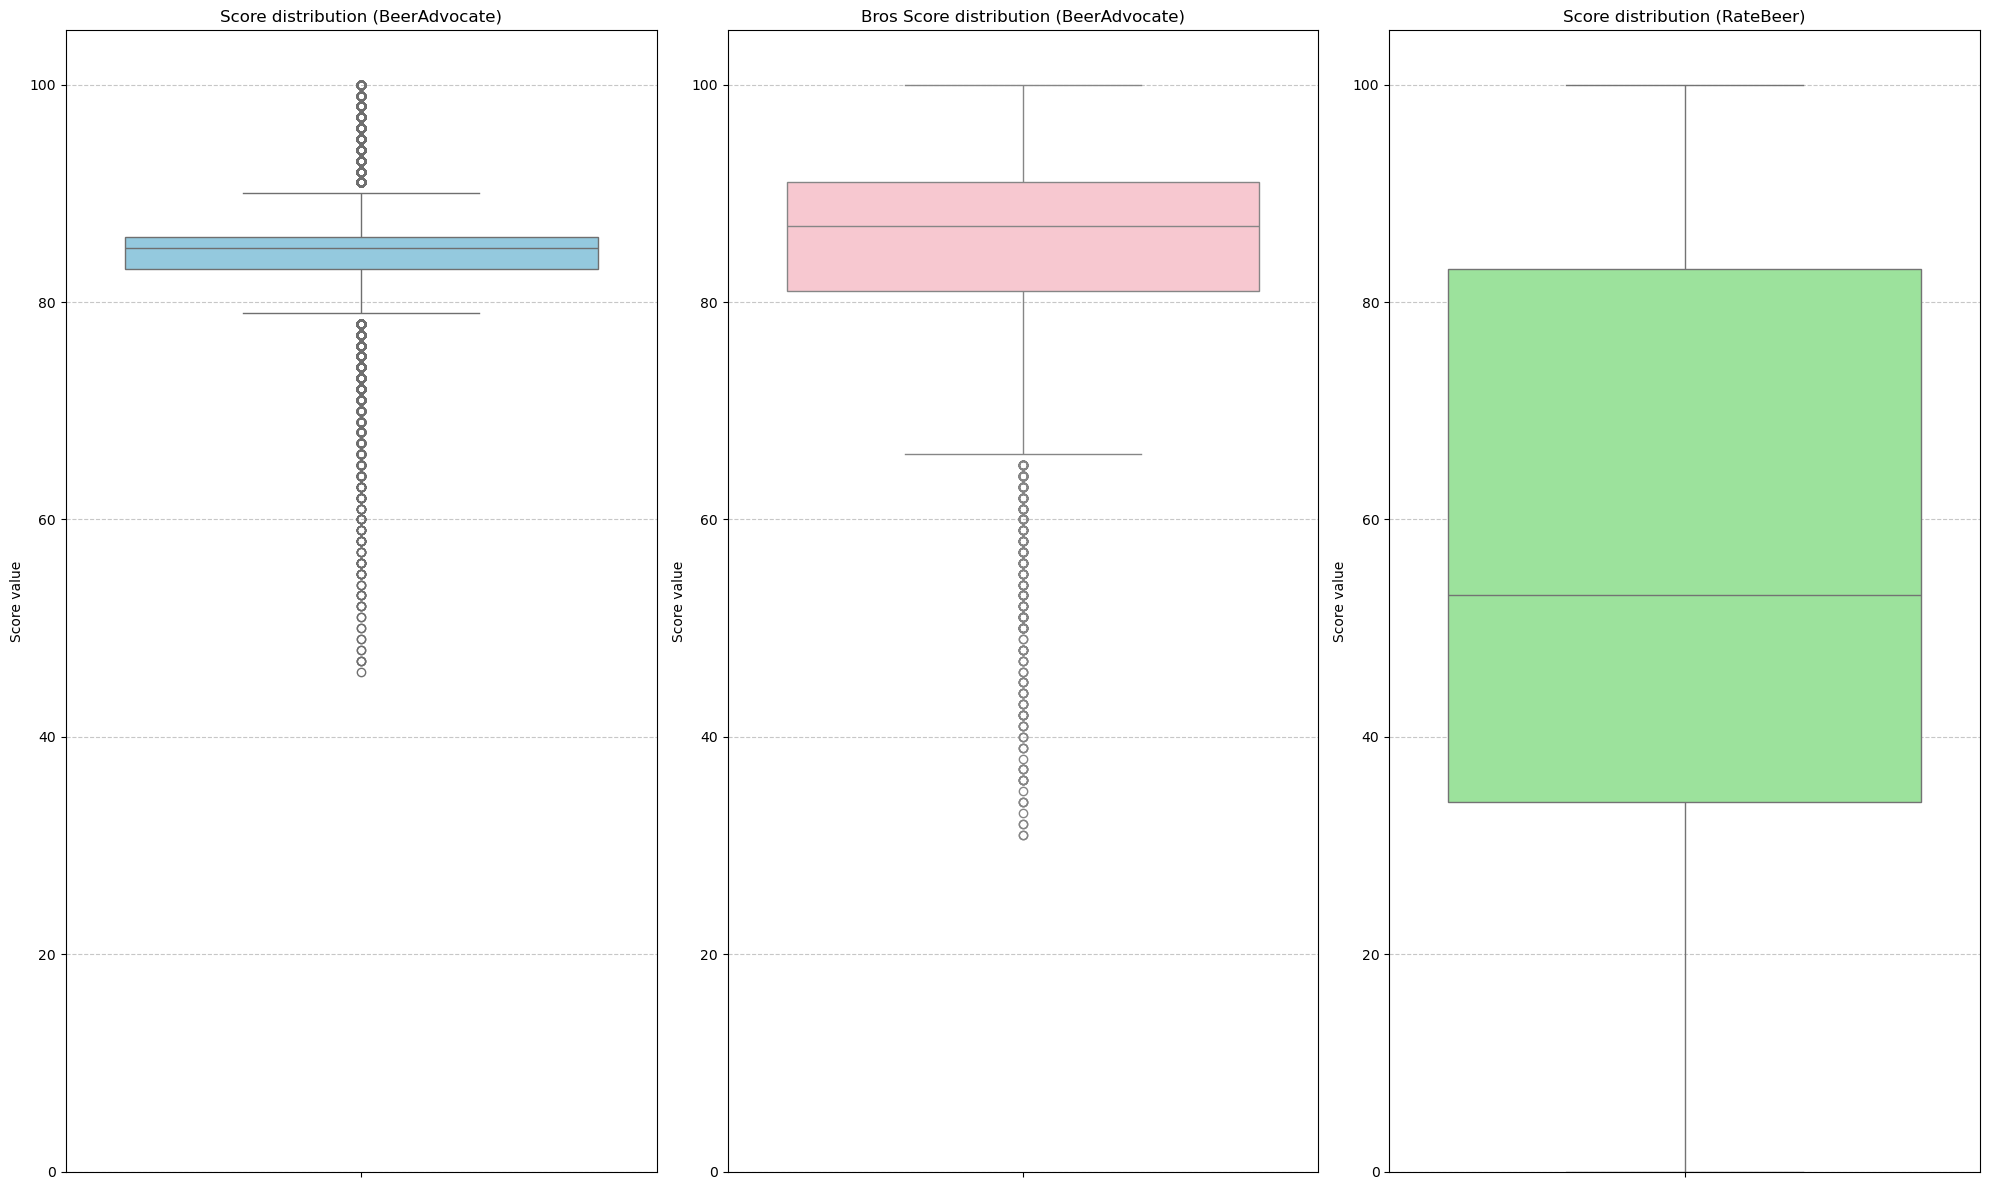

In [111]:
# Drop NA values for the scores 
beers_ba_f['ba_score'].dropna()
beers_rb_f['overall_score'].dropna()
beers_ba_f['bros_score'].dropna()

ba_score_count = beers_ba_f['ba_score'].value_counts()
rb_score_count = beers_rb_f['overall_score'].value_counts()
bros_score_count = beers_ba_f['bros_score'].value_counts()

plt.figure(figsize=(20, 12))
plt.subplot(1, 3, 1)
ax1 = sns.boxplot(beers_ba_f['ba_score'], color='skyblue')
plt.title('Score distribution (BeerAdvocate)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(beers_ba_f['bros_score'], color='pink')
plt.title('Bros Score distribution (BeerAdvocate)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(beers_rb_f['overall_score'], color='lightgreen')
plt.title('Score distribution (RateBeer)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

As we can see, beers on BeerAdvocate tend to have higher ratings than beers on RateBeer, which have more spread-out ratings. This is because BeerAdvocate's algorithm for calculating the score is a little different from RateBeer's algorithm. The former uses a custom Bayesian fomula, while the latter uses a true Bayesian estimate formula. [Score explanation BeerAdvocate](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/) & [Score explanation for RateBeer](https://www.ratebeer.com/our-scores)

The bros score on BeerAdvocate, which is the score that the founders of the website (so experts) give to the beers, can be a good metric to help us find define a trend. Indeed, we can see that the bros score is more spread out which might be a more accurate representation of the quality of the beer. This metric is only available on Beer Advocate.
Generally, people say they value the bros score when there score is above the average for less popular styles. It is something we must keep in mind for further analysis [Forum BA](https://link-url-here.org)

### Average score per style 

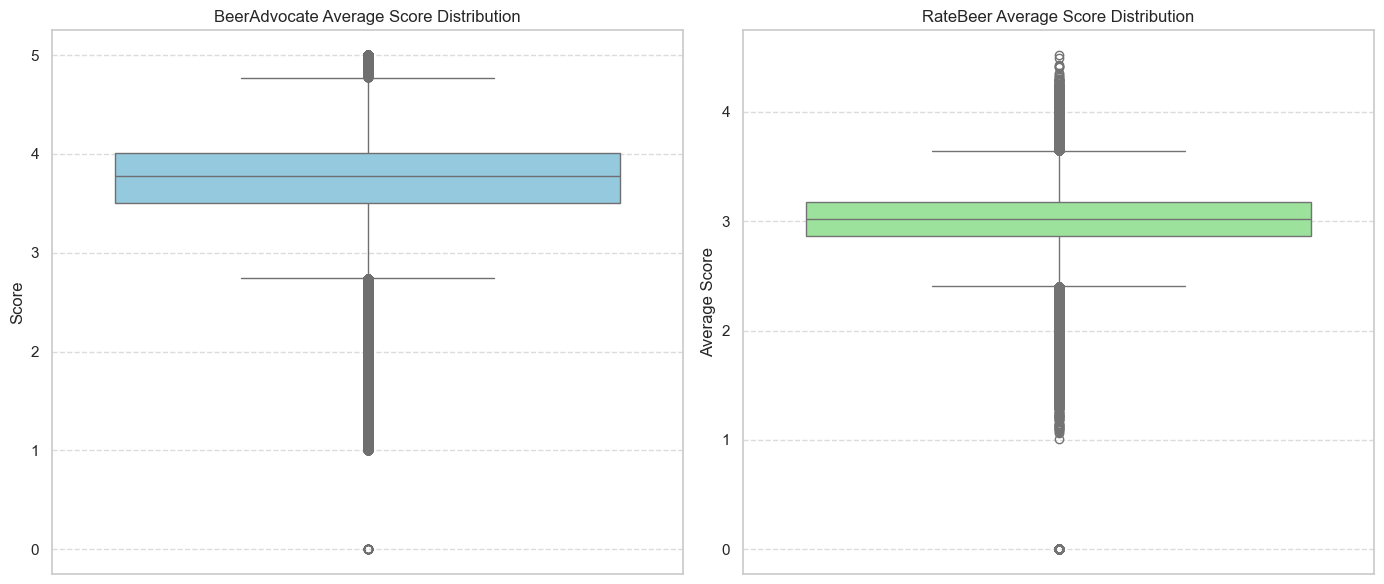

In [301]:
# Drop NA values for the average scores 
beers_ba_f['avg'].dropna()
beers_rb_f['avg'].dropna()

# Distribution of the average score 
plt.figure(figsize=(14, 6))

# Boxplot for BeerAdvocate
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(y=beers_ba_f['avg'], color='skyblue')
plt.title('BeerAdvocate Average Score Distribution')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Boxplot for RateBeer
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(y=beers_rb_f['avg'], color='lightgreen')
plt.title('RateBeer Average Score Distribution')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

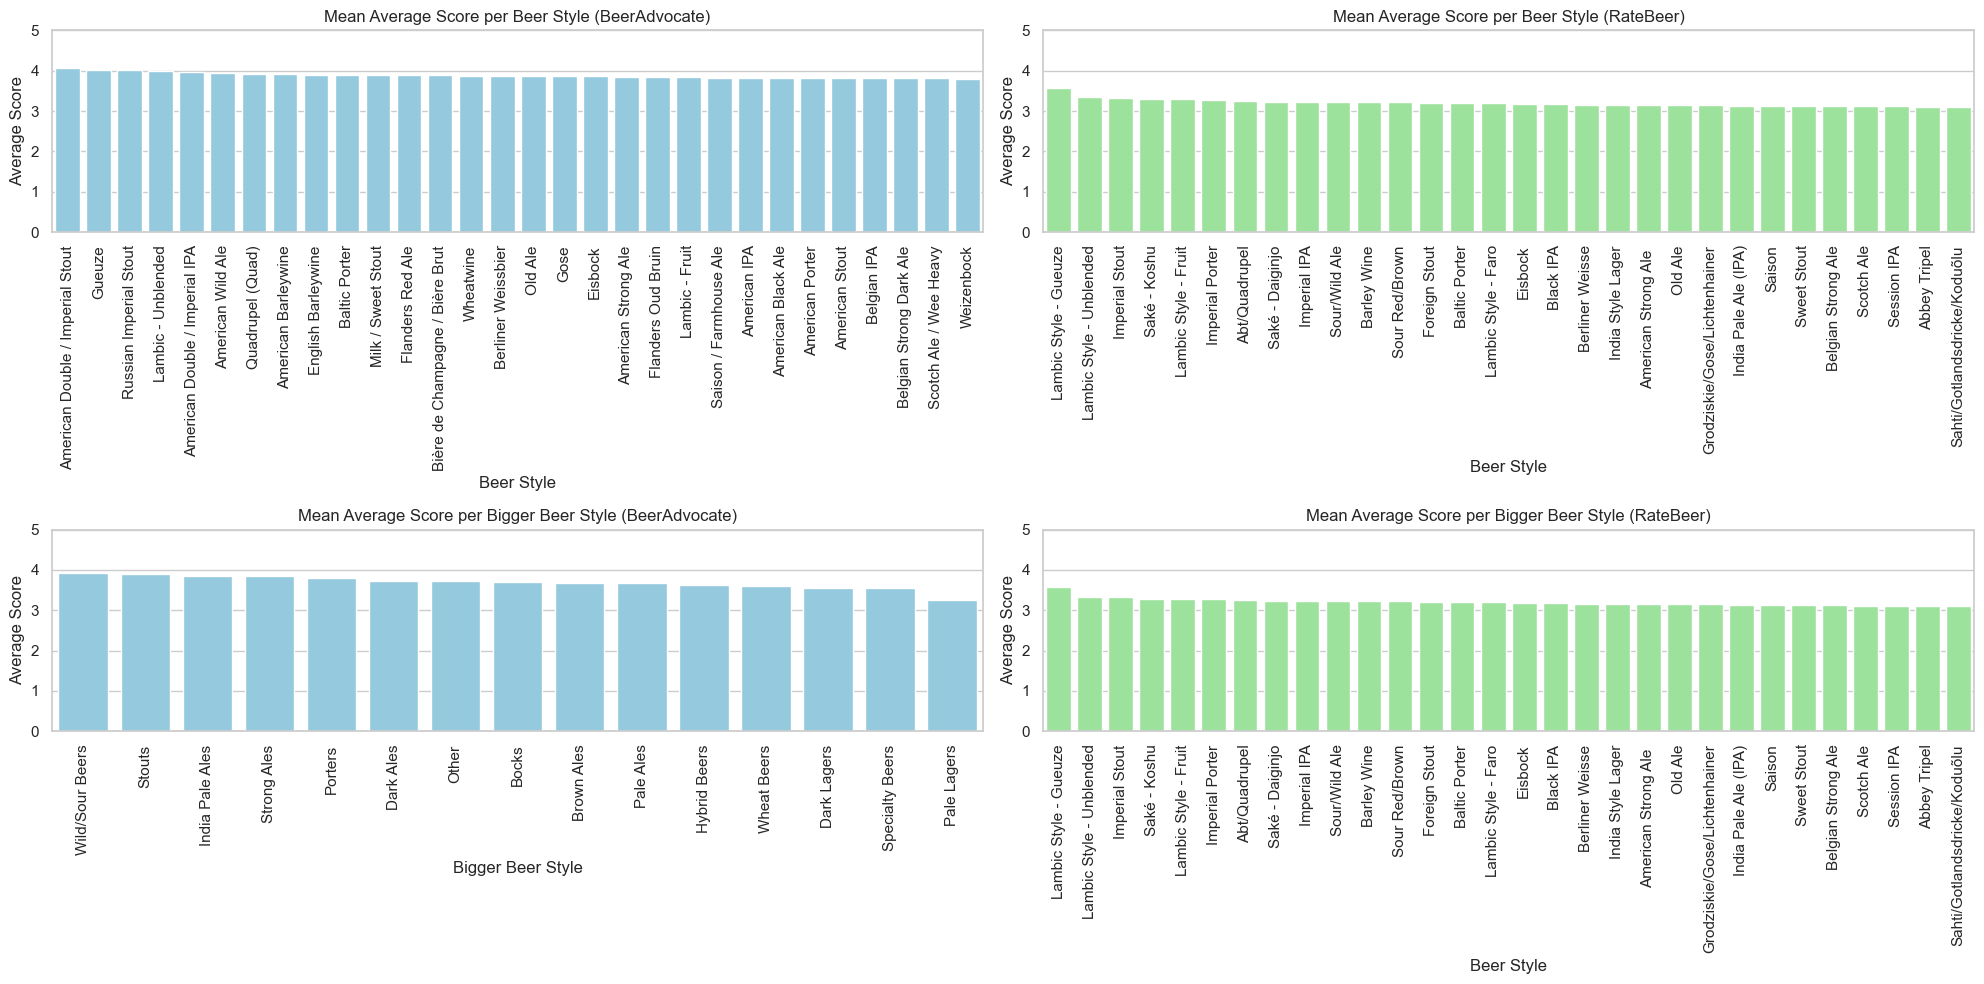

In [302]:
# Average score per style for BeerAdvocate 
ba_avg_style = beers_ba_f[['style', 'avg']].groupby('style').mean().reset_index()
ba_avg_style = ba_avg_style.sort_values(by='avg', ascending=False)
ba_avg_style = ba_avg_style.nlargest(30, 'avg') # only choosing the 30 largets mean average for better visualization 

# Average score per style for RateBeer
rb_avg_style = beers_rb_f[['style', 'avg']].groupby('style').mean().reset_index()
rb_avg_style = rb_avg_style.sort_values(by='avg', ascending=False)
rb_avg_style = rb_avg_style.nlargest(30, 'avg') # only choosing the 30 largets mean average for better visualization 

# Average score per bigger style for BeerAdvocate 
ba_avg_per_bigger_style = beers_ba_f[['bigger_style', 'avg']].groupby('bigger_style').mean().reset_index()
ba_avg_per_bigger_style = ba_avg_per_bigger_style.sort_values(by='avg', ascending=False)

# Average score per bigger style for RateBeer 
rb_avg_per_bigger_style = beers_rb_f[['bigger_style', 'avg']].groupby('bigger_style').mean().reset_index()
rb_avg_per_bigger_style = rb_avg_per_bigger_style.sort_values(by='avg', ascending=False)

plt.figure(figsize=(20, 10))

# Plot for BeerAdvocate
plt.subplot(2,2,1)
ax1 = sns.barplot(data=ba_avg_style, x='style', y='avg', color='skyblue')
plt.title('Mean Average Score per Beer Style (BeerAdvocate)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for RateBeer
plt.subplot(2,2,2)
ax1 = sns.barplot(data=rb_avg_style, x='style', y='avg', color='lightgreen')
plt.title('Mean Average Score per Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for BeerAdvocate
plt.subplot(2,2,3)
ax3 = sns.barplot(data=ba_avg_per_bigger_style, x='bigger_style', y='avg', color='skyblue')
plt.title('Mean Average Score per Bigger Beer Style (BeerAdvocate)')
plt.xlabel('Bigger Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for RateBeer
plt.subplot(2,2,4)
ax1 = sns.barplot(data=rb_avg_style, x='style', y='avg', color='lightgreen')
plt.title('Mean Average Score per Bigger Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

When looking at specific type of beers (not the bigger ones such as IPA, Stouts, Pale Ales, etc) we see that the average scores are pretty much the same. Even when looking at the mean average score for the bigger styles it is still the practically the same for all types of beers. Thus we can't use the average score as a metrics to predict the IPA trend. 
  

# 3. Geographical analysis of the trend 

Now that we have a little bit more insights on the beers, one might wonder what are the correlations between the variables we just studied and the location from where they come from, the breweries. One of our goal is to see where the IPA trend might come from. 

We will first look at the number of ratings across the continents and the countries. 

In [8]:
# Merge beers and brewery on brewery id
ba_beer_brewery = pd.merge(beers_ba_f, breweries_ba_f, left_on=['brewery_id'], right_on=['id'])
ba_beer_brewery = ba_beer_brewery.drop(columns=['avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

rb_beer_brewery= pd.merge(beers_rb_f, breweries_rb_f, left_on=['brewery_id'], right_on=['id'])
rb_beer_brewery = rb_beer_brewery.drop(columns=['avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

### Number of ratings per continent 

In [9]:
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
ba_beer_brewery['location_grouped'] = ba_beer_brewery['location'].apply(rename_country)
rb_beer_brewery['location_grouped'] = rb_beer_brewery['location'].apply(rename_country)

# Add a column for the ISO 3166 norm
ba_beer_brewery['location_with_iso'] = ba_beer_brewery['location_grouped'].apply(add_iso_code)
rb_beer_brewery['location_with_iso'] = rb_beer_brewery['location_grouped'].apply(add_iso_code)

# Convert every country into its corresponding continent into a new column 'continent'
ba_beer_brewery['continent'] = ba_beer_brewery['location_grouped'].apply(country_to_continent)
rb_beer_brewery['continent'] = rb_beer_brewery['location_grouped'].apply(country_to_continent)

C:\Users\thibh\AppData\Local\Temp\ipykernel_6016\222115890.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


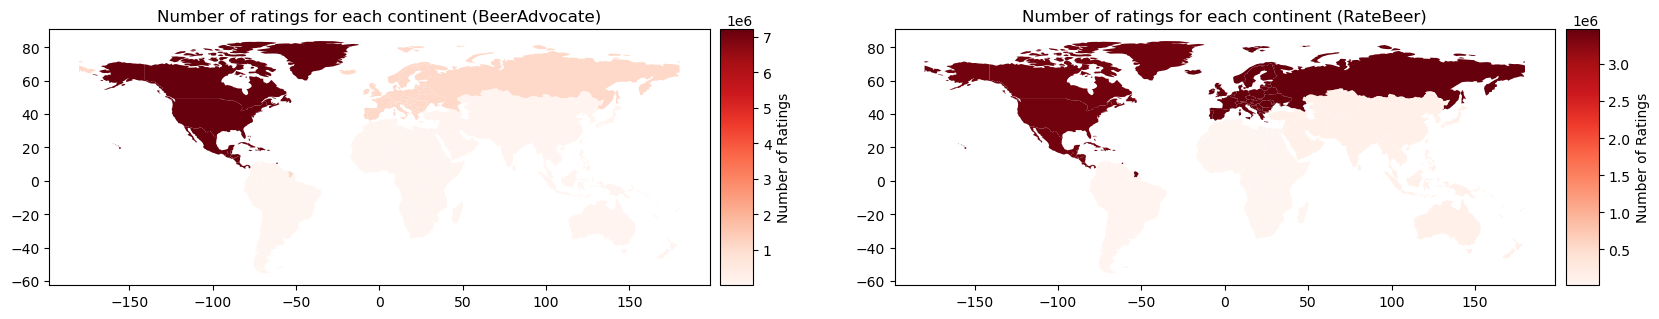

In [10]:
ba_nbr_ratings_per_continent = ba_beer_brewery.groupby('continent')['nbr_ratings'].sum()
rb_nbr_ratings_per_continent = rb_beer_brewery.groupby('continent')['nbr_ratings'].sum()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Map for BeerAdvocate
world_ba = world.merge(ba_nbr_ratings_per_continent, how='left', left_on='continent', right_index=True)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
world_ba.plot(column='nbr_ratings', ax=ax1, legend=True, cax=cax1, cmap='Reds', legend_kwds={'label': "Number of Ratings"})
ax1.set_title('Number of ratings for each continent (BeerAdvocate)')

# Map for RateBeer
world_rb = world.merge(rb_nbr_ratings_per_continent, how='left', left_on='continent', right_index=True)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
world_rb.plot(column='nbr_ratings', ax=ax2, legend=True, cax=cax2, cmap='Reds', legend_kwds={'label': "Number of Ratings"})
ax2.set_title('Number of ratings for each continent (RateBeer)')

plt.show()

Most ratings come from North America and Europe. Now we will have a closer look at the countries themselves. Notice that we don't have the same scale on the 2 maps.

### Number of ratings per country 

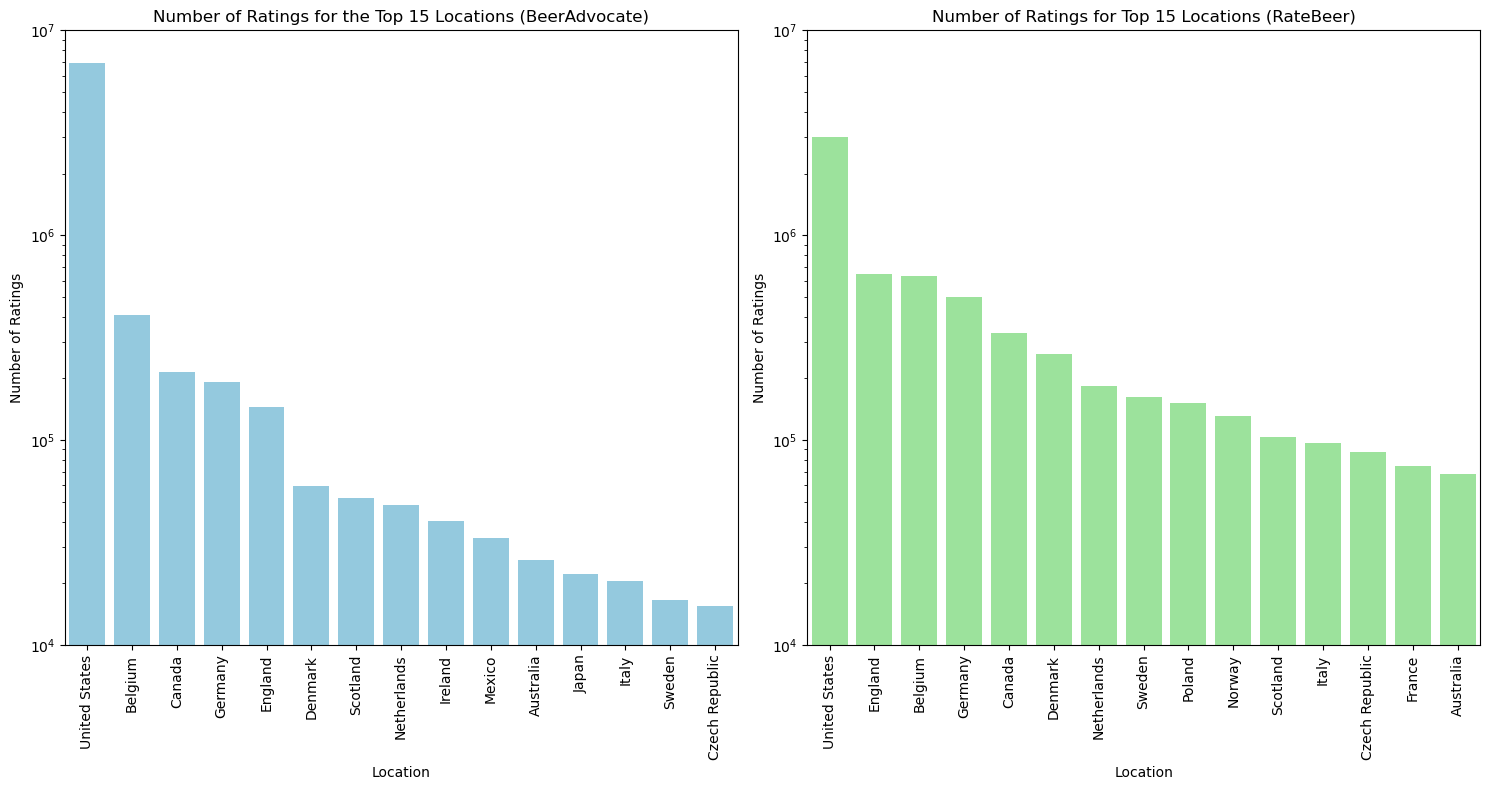

In [11]:
# Create a new column where all the states of the US are reunited 
ba_beer_brewery['countries'] = ba_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)
rb_beer_brewery['countries'] = rb_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

# Top 15 locations with the highest number of ratings
ba_highest_rated_per_location_top15 = ba_beer_brewery.groupby('countries')['nbr_ratings'].sum().nlargest(15)
rb_highest_rated_per_location_top15 = rb_beer_brewery.groupby('countries')['nbr_ratings'].sum().nlargest(15)

plt.figure(figsize=(15, 8)) 

# Plot for BeerAdvocate 
plt.subplot(1,2,1)
ax = sns.barplot(x=ba_highest_rated_per_location_top15.index, y=ba_highest_rated_per_location_top15.values, color='skyblue')
plt.title('Number of Ratings for the Top 15 Locations (BeerAdvocate)')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.ylim(10000, 10000000)
plt.xticks(rotation=90)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.barplot(x=rb_highest_rated_per_location_top15.index, y=rb_highest_rated_per_location_top15.values, color='lightgreen')
plt.title('Number of Ratings for Top 15 Locations (RateBeer)')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.ylim(10000, 10000000)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show() 

As we can see the number of ratings is not equal between each countries. One may think that a country with a lot of ratings might influence others. More specifically, the United States have a lot of ratings. However, normalizing by the population of each country might be more accurate and show us better the weight a country can have on the number of ratings. Then the idea would be to select these countries and see what styles are the most rated. 
In order to analyse the IPA trend we would look at which countries have been rating IPAs the most. 

Moreover, we can observe that the numer of ratings of the United States is quite high compared to other countries. Thus, taking a closer look at the ratings per states might be useful to analyse the trend.

### Number of ratings per US states

C:\Users\thibh\AppData\Local\Temp\ipykernel_6016\2855485956.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ba_beer_brewery_US = ba_beer_brewery_US[~http_ref_ba]


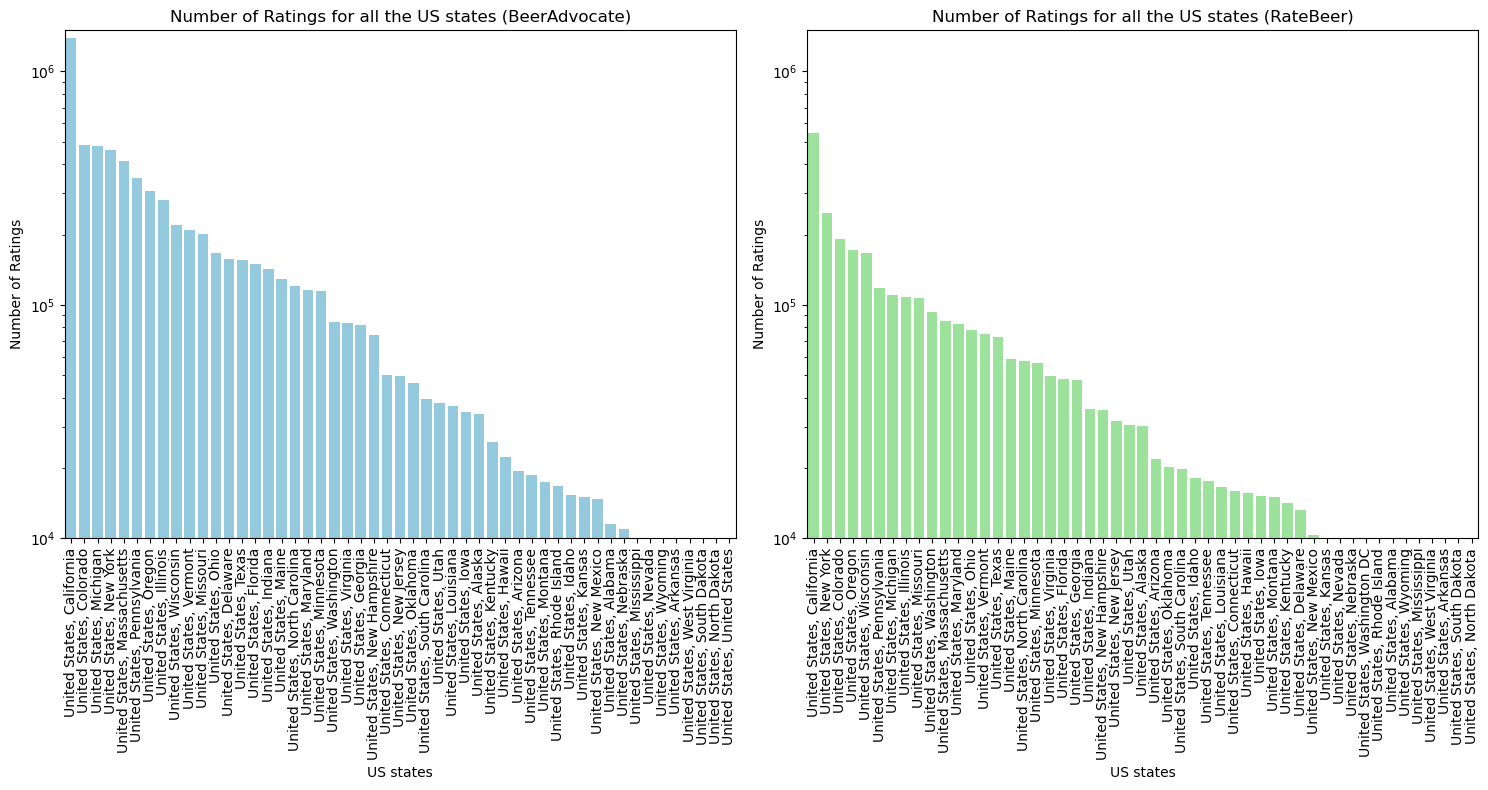

In [12]:
ba_beer_brewery_US = ba_beer_brewery.copy(deep=True)
rb_beer_brewery_US = rb_beer_brewery.copy(deep=True)

# Only keep the rows that are from the United States 
ba_beer_brewery_US = ba_beer_brewery[ba_beer_brewery['countries'] == 'United States']
rb_beer_brewery_US = rb_beer_brewery[rb_beer_brewery['countries'] == 'United States']

# Get rid of the states that aren't in the right format 
http_mask_ba = ba_beer_brewery_US['location'].str.contains('http')
http_ref_ba = ba_beer_brewery_US['location'].str.contains('href')
http_mask_rb = rb_beer_brewery_US['location'].str.contains('http')
http_ref_rb = rb_beer_brewery_US['location'].str.contains('href')

# Keep rows where 'location' does not contain "http" or "href"
ba_beer_brewery_US = ba_beer_brewery_US[~http_mask_ba]
ba_beer_brewery_US = ba_beer_brewery_US[~http_ref_ba]
rb_beer_brewery_US = rb_beer_brewery_US[~http_mask_rb]
rb_beer_brewery_US = rb_beer_brewery_US[~http_ref_rb]

ba_highest_rated_states = ba_beer_brewery_US.groupby('location')['nbr_ratings'].sum().sort_values(ascending=False)
rb_highest_rated_states = rb_beer_brewery_US.groupby('location')['nbr_ratings'].sum().sort_values(ascending=False)

plt.figure(figsize=(15, 8)) 

# Plot for BeerAdvocate 
plt.subplot(1,2,1)
ax1 = sns.barplot(x=ba_highest_rated_states.index, y=ba_highest_rated_states.values, color='skyblue')
plt.title('Number of Ratings for all the US states (BeerAdvocate)')
plt.xlabel('US states')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(10000, 1500000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.barplot(x=rb_highest_rated_states.index, y=rb_highest_rated_states.values, color='lightgreen')
plt.title('Number of Ratings for all the US states (RateBeer)')
plt.xlabel('US states')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(10000, 1500000)

plt.tight_layout()
plt.show() 

There is a significant difference for the number of ratings between the states. This is helpful to analyse the pattern of the trend within the US giving us an even closer look at the trend. 

### Breweries 
Studying variables such as the number of breweries and the diversity of brewed beers could show if the trend came from microbreweries or on the countrary from big breweries. 

C:\Users\thibh\AppData\Local\Temp\ipykernel_6016\2475312092.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10000)
C:\Users\thibh\AppData\Local\Temp\ipykernel_6016\2475312092.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10000)


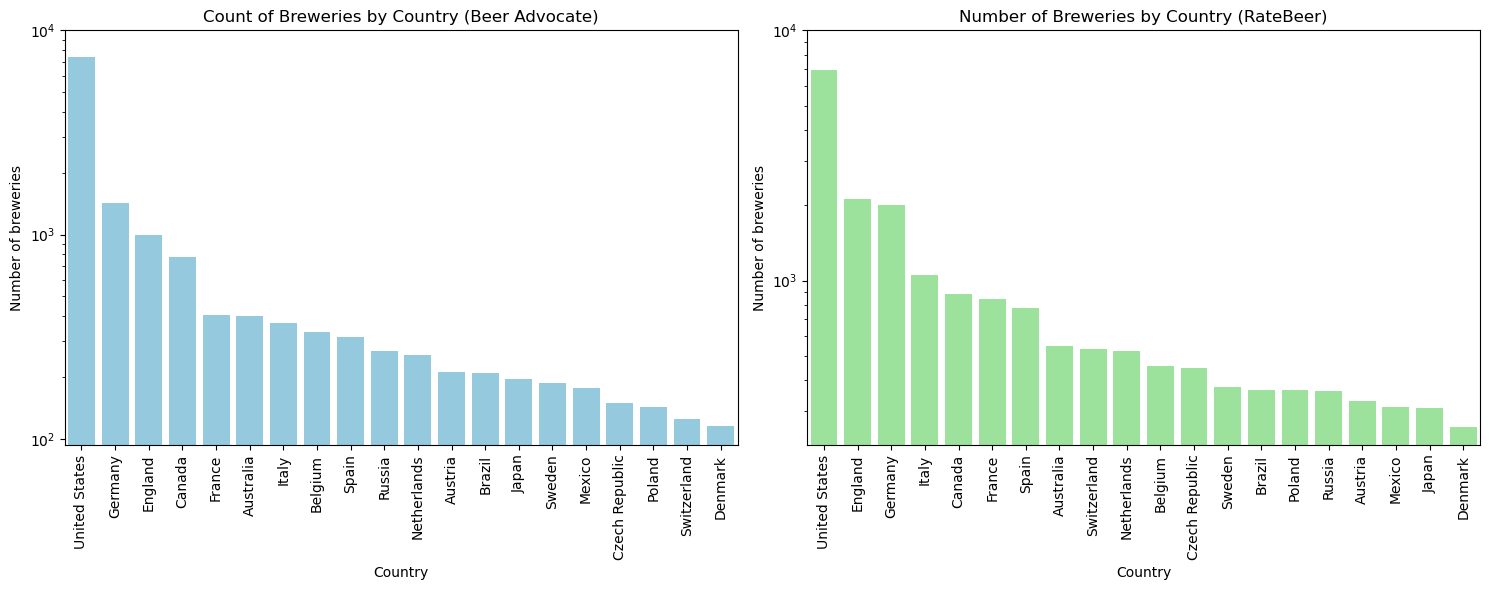

In [13]:
breweries_ba_f['countries'] = breweries_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 
                                                                 'United States' in x else x)
breweries_rb_f['countries'] = breweries_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 
                                                                 'United States' in x else x)

# Top 15 countries with the most breweries on RateBeer
nbr_breweries_rb = breweries_rb_f['countries'].value_counts().nlargest(20)
nbr_breweries_ba = breweries_ba_f['countries'].value_counts().nlargest(20)

# Plot for BeerAdvocate 
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=breweries_ba_f, x='countries', order=nbr_breweries_ba.index, color='skyblue')
plt.title('Count of Breweries by Country (Beer Advocate)')
plt.xlabel('Country')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,10000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.countplot(data=breweries_rb_f, x='countries', order=nbr_breweries_rb.index, color='lightgreen')
plt.title('Number of Breweries by Country (RateBeer)')
plt.xlabel('Country')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,10000)

plt.tight_layout()
plt.show()

Germany and England are definitely up there regarding the number of breweries. However, we can see that the United States are the country with the highest number of breweries. 

C:\Users\thibh\AppData\Local\Temp\ipykernel_6940\755601258.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000000)
C:\Users\thibh\AppData\Local\Temp\ipykernel_6940\755601258.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000000)


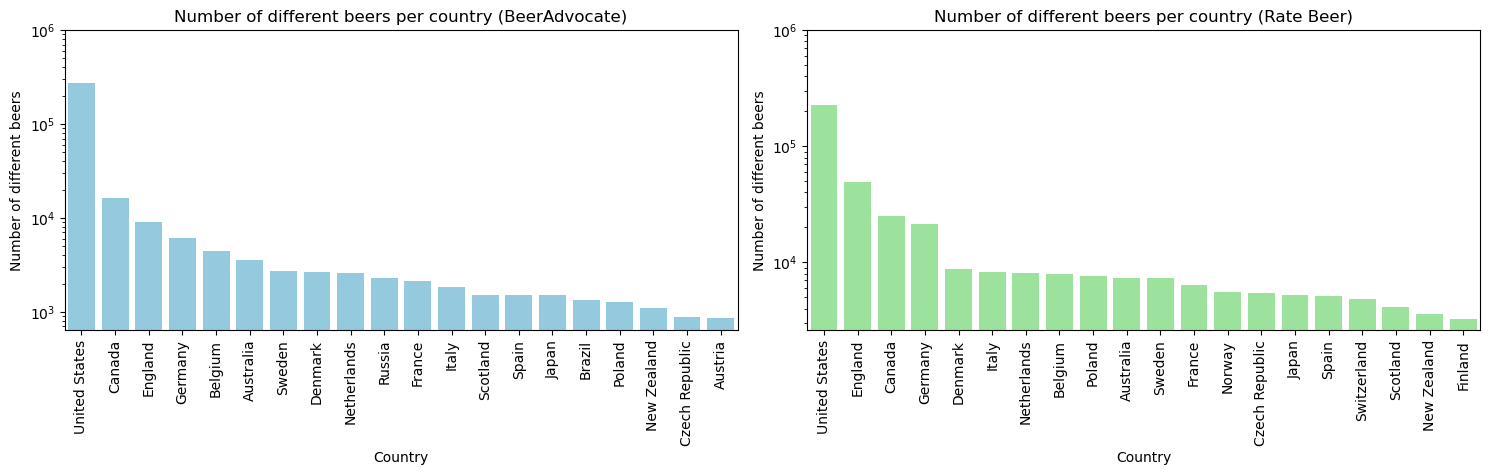

In [118]:
# Number of different beers per location 
rb_nbr_beer_location = breweries_rb_f.groupby('countries')['nbr_beers'].sum().nlargest(20)
ba_nbr_beer_location = breweries_ba_f.groupby('countries')['nbr_beers'].sum().nlargest(20)

plt.figure(figsize=(15, 8))  

plt.subplot(2,2,1)
ax1 = sns.barplot(x=ba_nbr_beer_location.index, y=ba_nbr_beer_location.values, color='skyblue')
plt.title('Number of different beers per country (BeerAdvocate)')
plt.xlabel('Country')
plt.ylabel('Number of different beers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0, 1000000)

plt.subplot(2,2,2)
ax2 = sns.barplot(x=rb_nbr_beer_location.index, y=rb_nbr_beer_location.values, color='lightgreen')
plt.title('Number of different beers per country (Rate Beer)')
plt.xlabel('Country')
plt.ylabel('Number of different beers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0, 1000000)

plt.tight_layout()
plt.show()

The United States is the country that has the highest number of different brewed beers. However, we can see that even for smaller countries such as Germany and England they are still in the top 5. For further analysis we could study the weight that each country has in the diversity of beers. Then we will be able to analyse the production of each style of beer for every country. More specifically we could see the country which produces the highest number of IPAs. 
Furthermore, we could normalize the number of beers by the population of each country and see which country produces the highest number of IPAs per habitants. This could help us identify countries where IPAs is trendy. 

# 4. Social analysis of the trend 

We will now focus on the type of users that rate the beers on the websites. Regarding the users we will look at their origin, the date in which they entered the websites, and the styles of beer they review. One important factor of a trend is the time so will mostly study these in a chronological way.  
One goal here would be to identify fan clubs which could be another metric to identify the trend of IPAs

### Number of users per country

C:\Users\thibh\AppData\Local\Temp\ipykernel_6940\3535490044.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000000)
C:\Users\thibh\AppData\Local\Temp\ipykernel_6940\3535490044.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000000)


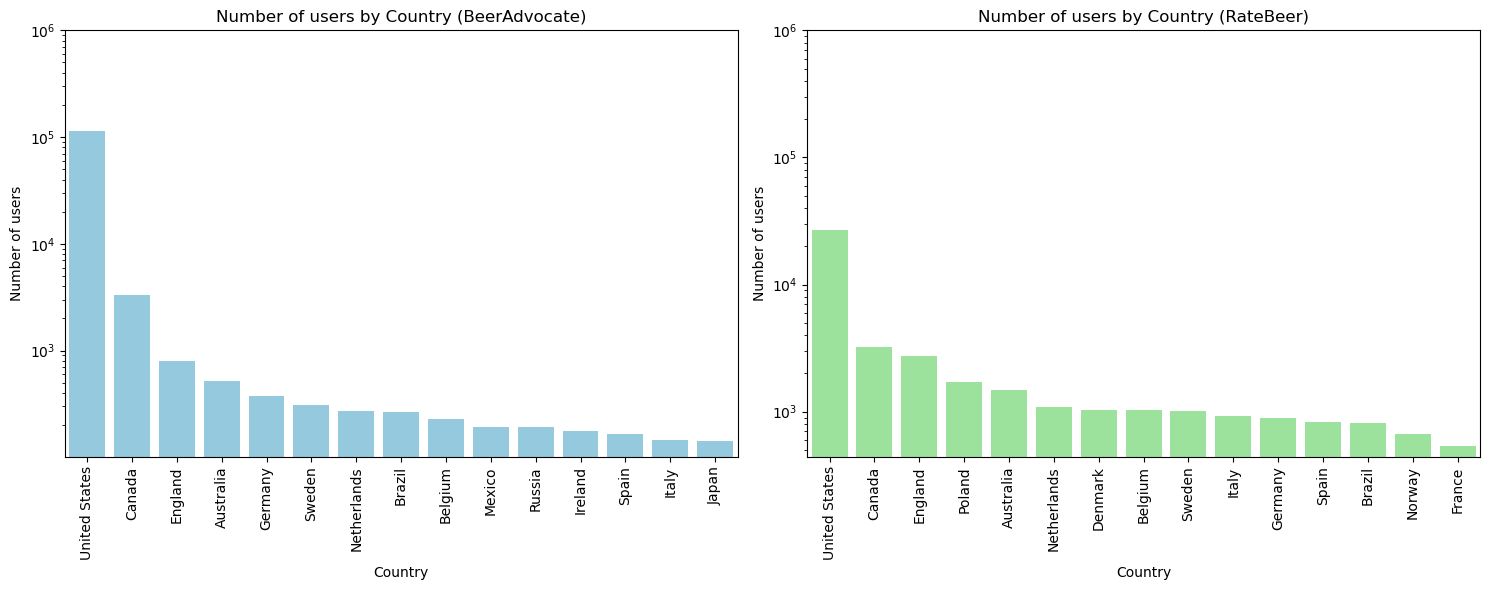

In [119]:
users_ba_f['location'] = users_ba_f['location'].dropna()
users_rb_f['location'] = users_rb_f['location'].dropna()

# Group variations of 'United States' in the 'country' column
users_ba_f['countries'] = users_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)
users_rb_f['countries'] = users_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

# Get the 15 most represented countries
nbr_users_ba = users_ba_f['countries'].value_counts().nlargest(15)
nbr_users_rb = users_rb_f['countries'].value_counts().nlargest(15)

# Plot for BeerAdvocate 
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=users_ba_f, x='countries', order=nbr_users_ba.index, color='skyblue')
plt.title('Number of users by Country (BeerAdvocate)')
plt.xlabel('Country')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,1000000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.countplot(data=users_rb_f, x='countries', order=nbr_users_rb.index, color='lightgreen')
plt.title('Number of users by Country (RateBeer)')
plt.xlabel('Country')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,1000000)

plt.tight_layout()
plt.show()

Most of the users are americans.

### Ratings from BeerAdvocate & RateBeer

Why Ratings instead of Reviews? Simply because Reviews is a subset of Ratings. So by analyzing the former, we analyze the latter.

### BeerAdvocate

In [121]:
# Start by loading reviews.csv from BeerAdvocate
#ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')
ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')

users_ba_f = users_ba.copy(deep=True)

# Load reviews.csv from RateBeer
#ratings_rb_f = pd.read_csv(f'{path_rb}/ratings.csv')
ratings_rb_f = pd.read_csv(f'{path_rb}/ratings.csv')

users_rb_f= users_rb.copy(deep=True)

In [312]:
# Merge users from BeerAdvocate in rating file with their countries info

ratings_ba_f = ratings_ba_f.merge(users_ba_f, on='user_name', how='left')
ratings_ba_f['location'] = ratings_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

ratings_ba_f['date'] = convert_to_date(ratings_ba_f['date'])
ratings_ba_f['joined'] = convert_to_date(ratings_ba_f['joined'])


# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
ratings_ba_f['date'] = pd.to_datetime(ratings_ba_f['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
ratings_ba_f['joined'] = pd.to_datetime(ratings_ba_f['joined'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

In [313]:
ratings_ba_f.isna().sum()

beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
abv               462
date                0
user_name           0
user_id_x           0
appearance      38598
aroma           38598
palate          38598
taste           38598
overall         38598
rating              0
text            53711
review              0
nbr_ratings         0
nbr_reviews         0
user_id_y           0
joined           3356
location         5506
dtype: int64

We identify more than 5,677,323 lines without comments. This is due to the use of BeerAdvocate ratings.csv, as the site does not require the user to submit a text with the ratings. We also have a large number of Nan for the different notes (appareance, arome, palate,...). Let's see if it's always the same users who tend to omit information.

In [314]:
# Delete duplicate users
ratings_ba_f.drop_duplicates(subset='user_name').isna().sum()

beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
abv               137
date                0
user_name           0
user_id_x           0
appearance       9480
aroma            9480
palate           9480
taste            9480
overall          9480
rating              0
text            12561
review              0
nbr_ratings         0
nbr_reviews         0
user_id_y           0
joined            636
location         1943
dtype: int64

We note the presence of 2,652 users whose date of joining BeerAdvocate is unknown. And 31,279 out of 153,705 did not specify their location. We can also see that the same users tend not to fill in all the data (abv, text, appearance, aroma, palate, taste, overall) as the number of Nan decreases when usernames duplicates are removed (this means we keep only one comment per user). 

We may have to remove these users, who provide little information.

### RateBeer

In [315]:
# Merge users from RateBeer in ratings file with their countries info

ratings_rb_f = ratings_rb_f.merge(users_rb_f, on='user_name', how='left')
ratings_rb_f['location'] = ratings_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)


ratings_rb_f['date'] = convert_to_date(ratings_rb_f['date'])
ratings_rb_f['joined'] = convert_to_date(ratings_rb_f['joined'])


# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
ratings_rb_f['date'] = pd.to_datetime(ratings_rb_f['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
ratings_rb_f['joined'] = pd.to_datetime(ratings_rb_f['joined'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

In [316]:
ratings_rb_f.isna().sum()

beer_name          0
beer_id            0
brewery_name       0
brewery_id         0
style              0
abv             2265
date               0
user_name          0
user_id_x          0
appearance         0
aroma              0
palate             0
taste              0
overall            0
rating             0
text               7
nbr_ratings        0
user_id_y          0
joined            13
location        3160
dtype: int64

We have no missing values, except for the alcohol content of the beer and the text, but the latter is very low and the degree of alcohol is of no interest to us in our study.
To study nbr_ratings, joined and location we need to remove duplicates. 

In [317]:
# Delete duplicate users to get other statistics 
ratings_rb_f.drop_duplicates(subset='user_name').isna().sum()

beer_name          0
beer_id            0
brewery_name       0
brewery_id         0
style              0
abv               64
date               0
user_name          0
user_id_x          0
appearance         0
aroma              0
palate             0
taste              0
overall            0
rating             0
text               2
nbr_ratings        0
user_id_y          0
joined             5
location        1284
dtype: int64

19,579 users out of 70,175 did not specify their location. Even if this number is high, it may represent users who don't post regularly (below 3 comments, the median number of ratings per beer). This should not be a problem for the rest of our project.
For the account creation date, the number of missing values is minimal.

In [318]:
# Verify that it is the case 
ratings_rb_f[ratings_rb_f['nbr_ratings'] >= 3].drop_duplicates(subset='user_name').isna().sum()

beer_name         0
beer_id           0
brewery_name      0
brewery_id        0
style             0
abv              44
date              0
user_name         0
user_id_x         0
appearance        0
aroma             0
palate            0
taste             0
overall           0
rating            0
text              2
nbr_ratings       0
user_id_y         0
joined            4
location        951
dtype: int64

We can see straight away that the number of users without a location has fallen sharply by selecting users with at least 3 reviews. 

### Score analysis

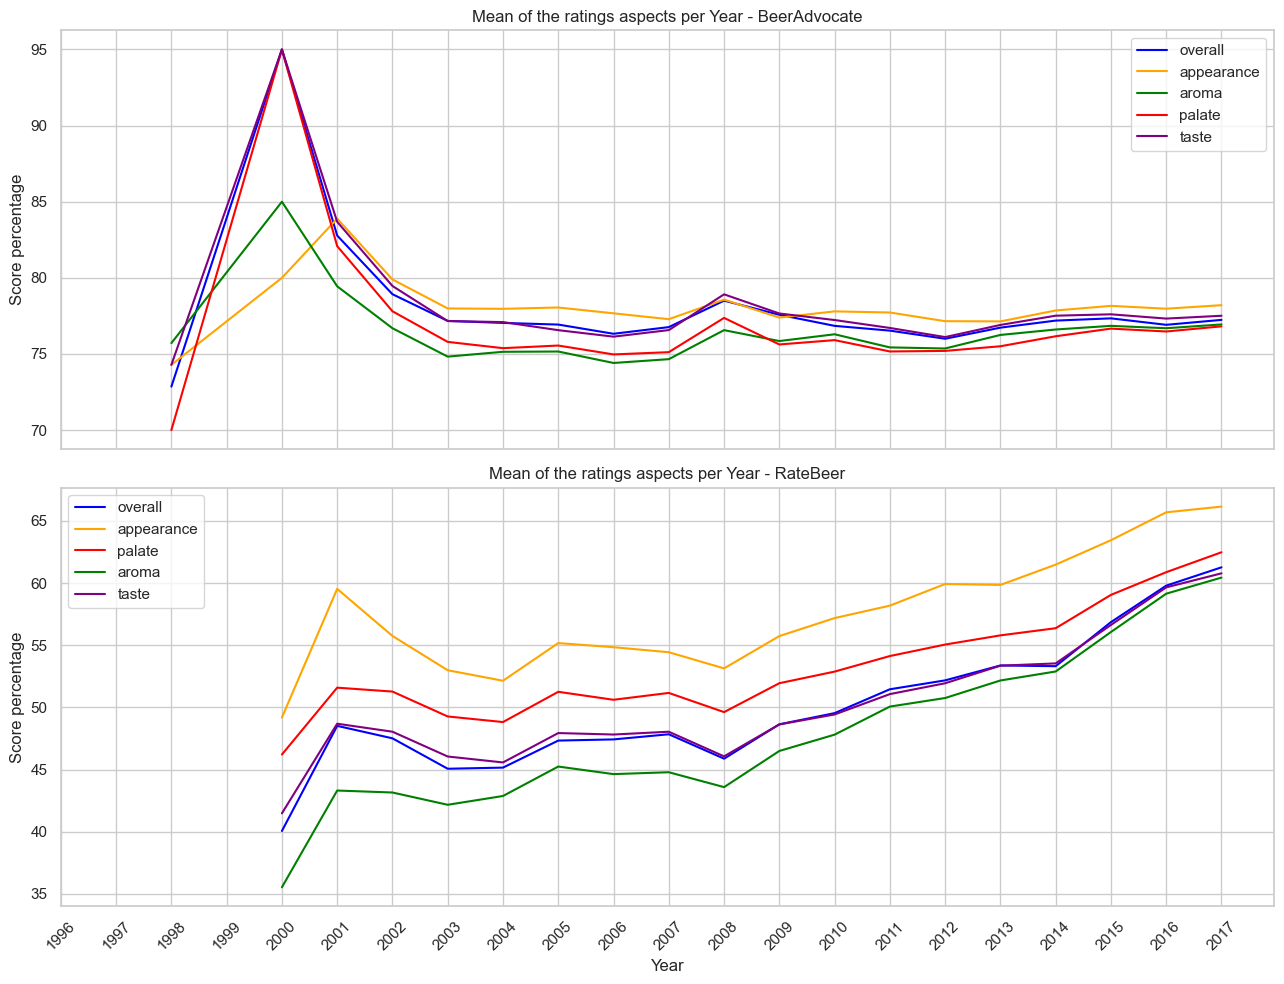

In [319]:
# Evolution of mean tastes along the years for RateBeer 
summary_df_rb = ratings_rb_f.groupby('date').agg({
    'overall': lambda x: (x.mean() / 20) * 100, ## Overwall is rated out of 20 
    'appearance': lambda x: (x.mean() / 5) * 100, ## Appearance is rated out of 5
    'aroma': lambda x: (x.mean() / 10) * 100, ## Taste is rated out of 10
    'palate': lambda x: (x.mean() / 5) * 100, ## Taste is rated out of 5
    'taste': lambda x: (x.mean() / 10) * 100 ## Taste is rated out of 5
}).reset_index()


# Evolution of mean tastes along the years for BeerAdvocate (Everything is rated out of 5)
summary_df_ba = ratings_ba_f.groupby('date').agg({
    'overall': lambda x: (x.mean() / 5) * 100,
    'appearance': lambda x: (x.mean() / 5) * 100,
    'aroma': lambda x: (x.mean() / 5) * 100,
    'palate': lambda x: (x.mean() / 5) * 100,
    'taste': lambda x: (x.mean() / 5) * 100
}).reset_index()

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(13, 10), sharex=True)

# Plot for BeerAdvocate
axs[0].plot(summary_df_ba['date'], summary_df_ba['overall'], label='overall',color='blue')
axs[0].plot(summary_df_ba['date'], summary_df_ba['appearance'], label='appearance',color='orange')
axs[0].plot(summary_df_ba['date'], summary_df_ba['aroma'], label='aroma',color='green')
axs[0].plot(summary_df_ba['date'], summary_df_ba['palate'], label='palate',color='red')
axs[0].plot(summary_df_ba['date'], summary_df_ba['taste'], label='taste',color='purple')
axs[0].set_ylabel('Score percentage')
axs[0].set_title('Mean of the ratings aspects per Year - BeerAdvocate')
axs[0].legend()

# Plot for RateBeer
axs[1].plot(summary_df_rb['date'], summary_df_rb['overall'], label='overall',color='blue')
axs[1].plot(summary_df_rb['date'], summary_df_rb['appearance'], label='appearance',color='orange')
axs[1].plot(summary_df_rb['date'], summary_df_rb['palate'], label='palate',color='red')
axs[1].plot(summary_df_rb['date'], summary_df_rb['aroma'], label='aroma',color='green')
axs[1].plot(summary_df_rb['date'], summary_df_rb['taste'], label='taste',color='purple')
axs[1].set_ylabel('Score percentage')
axs[1].set_xlabel('Year')
axs[1].set_title('Mean of the ratings aspects per Year - RateBeer')
axs[1].set_xticks(np.arange(1996, 2018, step=1))
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

It can be seen that, on average, scores tend to increase on both sites. We have comments from 1996 users on BeerAdvocate. Let's see how many there are:

### Number of comments per years for both datasets:

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (21,) and arg 1 with shape (19,).

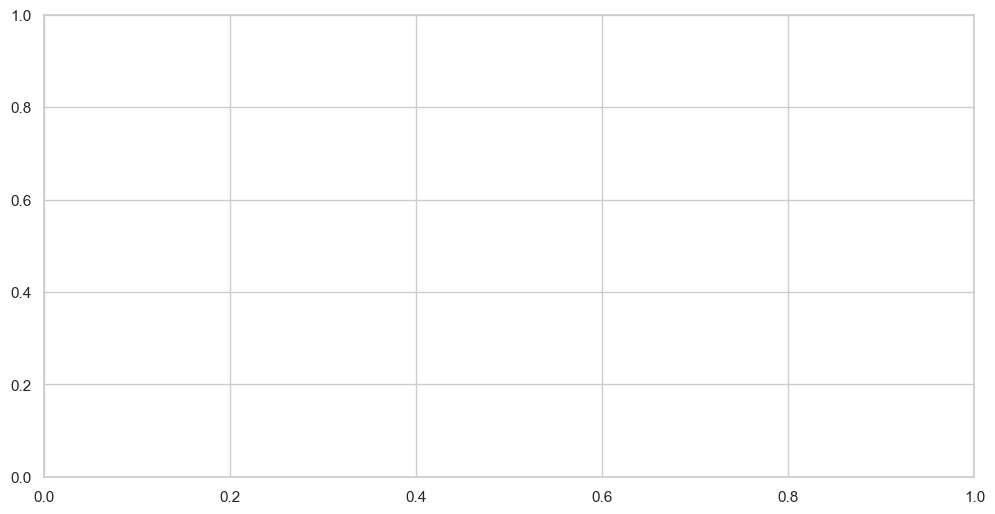

In [320]:
# For BeerAdvocate
comments_per_year_ba = ratings_ba_f.groupby('date')["text"].count().reset_index()
comments_per_year_ba.columns = ['Year', 'nb of comments']

# For Ratebeer
comments_per_year_rb = ratings_rb_f.groupby('date')["text"].count().reset_index()
comments_per_year_rb.columns = ['Year', 'nb of comments']

# Add values from 1996 to 1999
missing_years = pd.DataFrame({'Year': [1996, 1998, 1999], 'nb of comments': [0, 0, 0]})
comments_per_year_rb = pd.concat([missing_years, comments_per_year_rb]).sort_values('Year')

years = np.array([year for year in range(1996, 2018) if year != 1997])

bar_width = 0.35  # Largeur des barres

plt.figure(figsize=(12, 6))

plt.bar(years - bar_width/2, comments_per_year_ba['nb of comments'], bar_width, color='skyblue', label='BeerAdvocate', edgecolor='black')
plt.bar(years + bar_width/2, comments_per_year_rb['nb of comments'], bar_width, color='lightgreen', label='Ratebeer', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.yscale('log')
plt.title('Number of Comments per Year')
plt.xticks(years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

There was only one comment in 1996 and 0 in 1997. With further verification (not detailed here) we were able to see that it was the founder of BeerAdvocate (Todd Alström) who wrote this comment in 1996.

In any case, what we can see here is that to try and identify a trend in beer consumption, we can't base ourselves on years too close to creation. Instead, look for years when the number of comments has exceeded 10^4. So around 2002. 

### Number of new users per years for both datasets:

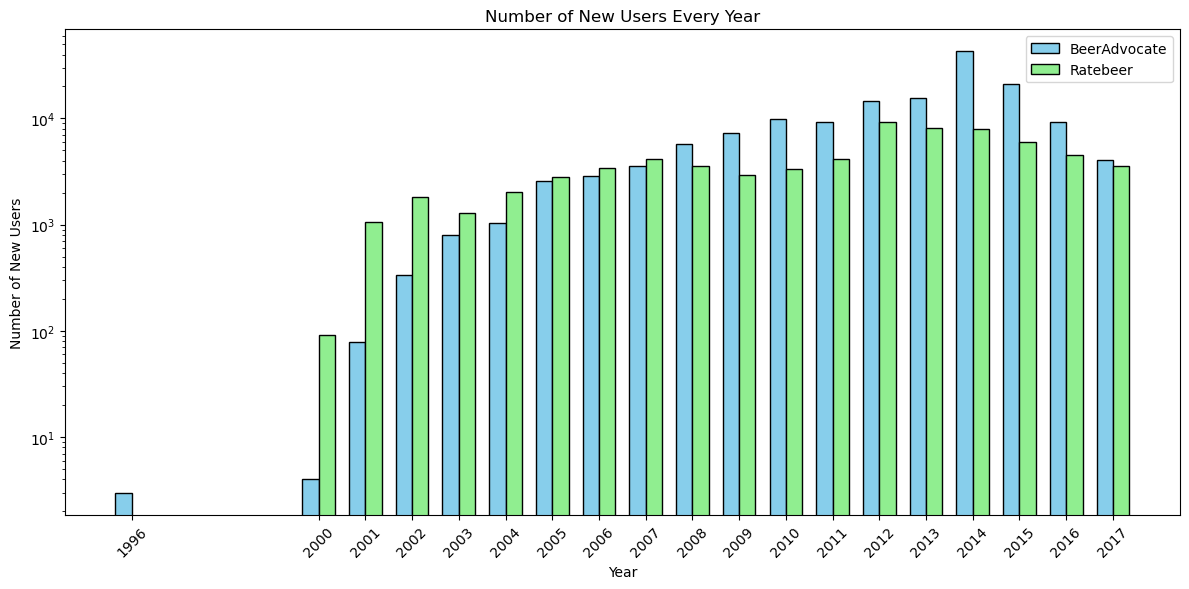

In [ ]:
# New users computation for RateBeer
new_users_per_year_rb = ratings_rb_f.groupby('joined')['user_id_y'].nunique().reset_index()

# New users computation for BeerAdvocate
new_users_per_year_ba = ratings_ba_f.groupby('joined')['user_id_y'].nunique().reset_index()

# Add values for 1996
missing_years = pd.DataFrame({'joined': [1996], 'nb of user_id_y': [0]})
new_users_per_year_rb = pd.concat([missing_years, new_users_per_year_rb]).sort_values('joined')

years = np.array([year for year in range(1996, 2018) if year not in [1997, 1998, 1999]])

bar_width = 0.35  # Width of bar 

plt.figure(figsize=(12, 6))

plt.bar(years - bar_width/2, new_users_per_year_ba['user_id_y'], bar_width, color='skyblue', label='BeerAdvocate', edgecolor='black')
plt.bar(years + bar_width/2, new_users_per_year_rb['user_id_y'], bar_width, color='lightgreen', label='Ratebeer', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Number of New Users')
plt.title('Number of New Users Every Year')
plt.xticks(years, rotation=45)
plt.yscale('log')
plt.legend()
plt.tight_layout()

One interesting thing can be identified from these two barplots: although BeerAdvocate seems to attract more new users every year than RateBeer, there are more comments per year on the latter. The reason for this is that RateBeer requires its users to comment on the beers.

In any case, the number of new users seems to correlate with the number of comments per year.

### Exploring grades

We can look at the rating column, which is the weighted average of 'palate', 'taste', 'aroma', 'appearance' and 'overall'. But since the rating scales are different (RateBeer uses different scales, e.g. between appearance and taste, as we saw earlier), it's best to standardize them for proper analysis. 

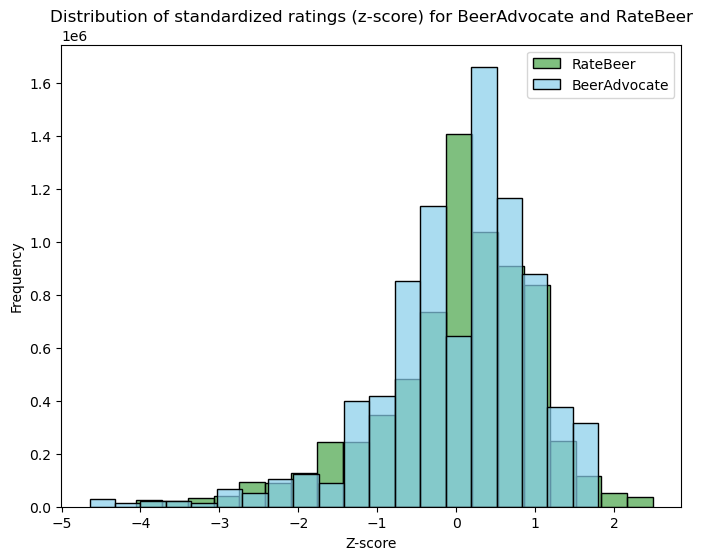

In [ ]:
# Apply a Z-score for 'ratings' in RateBeer ratings
ratings_zscore_rb = (ratings_rb_f['rating'] - ratings_rb_f['rating'].mean()) / ratings_rb_f['rating'].std()

# Apply a Z-score for 'ratings' in BeerAdvocate ratings
ratings_zscore_ba = (ratings_ba_f['rating'] - ratings_ba_f['rating'].mean()) / ratings_ba_f['rating'].std()

plt.figure(figsize=(8, 6))

sns.histplot(ratings_zscore_rb, bins=20, color='green', alpha=0.5, label='RateBeer')
sns.histplot(ratings_zscore_ba, bins=20, color='skyblue', alpha=0.7, label='BeerAdvocate')

plt.title('Distribution of standardized ratings (z-score) for BeerAdvocate and RateBeer')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In general, we can see that the ratings for RateBeer and BeerAdvocate are quite similar, but RateBeer has more high ratings.

# 5. Language processing

### For BeerAdvocate 

In [ ]:
# Chunk size
chunk_size = 1000

# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text
    
# Create a Reader object to read the CSV file in chunks
csv_reader = pd.read_csv(f"{path_ba}/reviews.csv", chunksize=chunk_size, encoding='utf-8')

# Iterate through all chunks
for chunk in csv_reader:
    # Initialize a list to store language vectors for the current chunk
    chunk_lang_vectors = []
    
    for index, row in chunk.iterrows():
        try:
            # Apply the language detection function to the text column
            # Unknown if NAN
            lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

        except Exception as e:
            # Clean the text only for the row that caused an error
            cleaned_text = clean_text(str(row['text']))
            # Reapply language detection after cleaning
            lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

    # Concatenate the language vectors for the current chunk
    chunk_lang_series = pd.Series(chunk_lang_vectors, name='lang')
    lang_vectors.append(chunk_lang_series)

# Concatenate all language vectors into a single vector
result_lang_vector = pd.concat(lang_vectors, ignore_index=True)

# Display
print(result_lang_vector.unique())

NameError: name 'cld2' is not defined

In [ ]:
# Plot percentage

# Calculate the counts of each language
lang_counts = result_lang_vector.value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color="skyblue", logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.show()

print(f"Percentage of unrecognized language: {lang_percentages.get('Unknown', 0):.4f}%")
print(f"Percentage of empty comments: {lang_percentages.get('NaN', 0):.5f}%")


Unsurprisingly, over 99% of comments are written in English, 0.0014% of comments are in a language not recognized by cld2 and a very small number are empty.
We can have a quick look at the distribution of languages if we remove users from USA knowing (from the previous analysis) that they are the most numerous users of this site.

In [ ]:
# Start by loading reviews.csv from BeerAdvocate
reviews_ba_f = pd.read_csv(f'{path_ba}/reviews.csv', usecols=['user_name','text'])

# Use column user_name and location only
users_ba_f= users_ba[["user_name","location"]].copy(deep=True)

# Remove states info, keep only Country
users_ba_f['location'] = users_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

In [ ]:
# Merge on User_name and remove United States
reviews_ba_f = reviews_ba_f.merge(users_ba_f, on='user_name', how='left')
reviews_ba_f = reviews_ba_f[reviews_ba_f['location'] != 'United States']

In [ ]:
# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Iterate through all rows in the DataFrame
for index, row in reviews_ba_f.iterrows():
    try:
        # Apply the language detection function to the text column
        # Unknown if NaN
        lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

    except Exception as e:
        # Clean the text only for the row that caused an error
        cleaned_text = clean_text(str(row['text']))
        # Reapply language detection after cleaning
        lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

# Create a new column 'lang' in the reviews_ba_f DataFrame
reviews_ba_f['lang'] = lang_vectors

# Display the unique languages detected
print(reviews_ba_f['lang'].unique())

In [ ]:
# Calculate the counts of each language
lang_counts = reviews_ba_f['lang'].value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color="skyblue", logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate excluding US users')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.plot()

Surprisingly (or not), even if you remove users from the USA, the most widely spoken language is still English.

### For RateBeer

In [ ]:
# Chunk size
chunk_size = 1000

# Initialize a list to store language vectors
lang_vectors_rb = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Create a Reader object to read the CSV file in chunks
csv_reader = pd.read_csv(f"{path_rb}/reviews.csv", chunksize=chunk_size, encoding='utf-8')

# Iterate through all chunks
for chunk in csv_reader:
    # Initialize a list to store language vectors for the current chunk
    chunk_lang_vectors = []
    
    for index, row in chunk.iterrows():
        try:
            # Apply the language detection function to the text column
            # Unknown if NAN
            lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

        except Exception as e:
            # Clean the text only for the row that caused an error
            cleaned_text = clean_text(str(row['text']))
            # Reapply language detection after cleaning
            lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

    # Concatenate the language vectors for the current chunk
    chunk_lang_series = pd.Series(chunk_lang_vectors, name='lang')
    lang_vectors_rb.append(chunk_lang_series)

# Concatenate all language vectors into a single vector
result_lang_vector_rb = pd.concat(lang_vectors_rb, ignore_index=True)

# Display the result
print(result_lang_vector_rb.unique())

In [ ]:
# Plot ratio

# Calculate the counts of each language
lang_counts_rb = result_lang_vector_rb.value_counts()

# Calculate the ratio of each language
lang_percentages_rb = lang_counts_rb / lang_counts_rb.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages_rb.plot(kind='bar', color="lightgreen",logy=True)
plt.title('Language Distribution in reviews from Ratebeer')
plt.xlabel('Language')
plt.ylabel('Percentage')

plt.show()

print(f"Percentage of unrecognized language: {lang_percentages_rb.get('Unknown', 0):.4f}%")
print(f"Percentage of empty comments: {lang_percentages_rb.get('NaN', 0):.4f}%")

Once again, English is by far the dominant language. However, there are many more languages than in BeerAdvocate.
There are also more empty comments and unrecognized languages. This is due to the number of comments, as RateBeer's dataset contains 7 122 074 comments compared to the 2 589 586 comments in BeerAdvocate's dataset.

As before, let's look at the distribution of languages without users living in the USA. 

In [ ]:
# Start by loading reviews.csv from RateBeer
reviews_rb_f = pd.read_csv(f'{path_rb}/reviews.csv', usecols=['user_name','text'])

users_rb_f= users_rb[["user_name","location"]].copy(deep=True)
users_rb_f['location'] = users_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

In [ ]:
# Merge on User_name and remove United States
reviews_rb_f = reviews_rb_f.merge(users_rb_f, on='user_name', how='left')
reviews_rb_f = reviews_rb_f[reviews_rb_f['location'] != 'United States']

In [ ]:
# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Iterate through all rows in the DataFrame
for index, row in reviews_rb_f.iterrows():
    try:
        # Apply the language detection function to the text column
        # Unknown if NaN
        lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

    except Exception as e:
        # Clean the text only for the row that caused an error
        cleaned_text = clean_text(str(row['text']))
        # Reapply language detection after cleaning
        lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

# Create a new column 'lang' in the reviews_ba_f DataFrame
reviews_rb_f['lang'] = lang_vectors

# Display the unique languages detected
print(reviews_rb_f['lang'].unique())

In [ ]:
# Calculate the counts of each language
lang_counts = reviews_rb_f['lang'].value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color="lightgreen", logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate excluding US users')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.plot()

Considering the language analysis of both websites we will only keep the reviews that are written in english.

# Project Milestone P3:

## Statistical test on the grades:

In [ ]:
# Anova test for BeerAdvocate 
styles = ratings_ba_f['style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_ba_f['rating'][ratings_ba_f['style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 27041.409528730757
P-value: 0.0


In [ ]:
# Anova test for RateBeer
styles = ratings_rb_f['style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_rb_f['rating'][ratings_rb_f['style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 42614.13844927083
P-value: 0.0


In [ ]:
# Anova test for bigger categories of BeerAdvocate 
# For each category find the broader style associated to the beer style
ratings_ba_f['bigger_style'] = ratings_ba_f['style'].apply(categorize_style)
styles = ratings_ba_f['bigger_style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_ba_f['rating'][ratings_ba_f['bigger_style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 112814.6357193032
P-value: 0.0


In [ ]:
# Anova test for bigger categories of RateBeer 
# For each category find the broader style associated to the beer style
ratings_rb_f['bigger_style'] = ratings_rb_f['style'].apply(categorize_style)
styles = ratings_rb_f['bigger_style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_rb_f['rating'][ratings_rb_f['bigger_style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 176844.39851397127
P-value: 0.0


Given than for every ANOVA tests we have p-value < 0.05, we know that there is at least one beer style that has a mean significantly different than other styles. To understand which styles have different mean, we will perform a posthoc analysis with tukey's hsd test (hhonest significance test). For the sake of simplicity, we will do this only on broader styles

In [ ]:
tukey_result_ba = pairwise_tukeyhsd(ratings_ba_f['rating'], ratings_ba_f['bigger_style'])
tukey_result_rb = pairwise_tukeyhsd(ratings_rb_f['rating'], ratings_rb_f['bigger_style'])

# Display the significant styles for each website
print("Tukey's HSD results for BeerAdvocate")
print(tukey_result_ba)

print("Tukey's HSD results for RateBeer")
print(tukey_result_rb)

Tukey's HSD results for BeerAdvocate
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------
          Bocks      Brown Ales  -0.0663   0.0 -0.0725   -0.06   True
          Bocks       Dark Ales   0.0219   0.0  0.0158   0.028   True
          Bocks     Dark Lagers  -0.2272   0.0 -0.2333 -0.2211   True
          Bocks    Hybrid Beers   -0.161   0.0 -0.1708 -0.1513   True
          Bocks India Pale Ales   0.1971   0.0   0.192  0.2021   True
          Bocks           Other   0.0589   0.0  0.0515  0.0662   True
          Bocks       Pale Ales   -0.036   0.0 -0.0411 -0.0309   True
          Bocks     Pale Lagers  -0.7022   0.0 -0.7078 -0.6967   True
          Bocks         Porters   0.1284   0.0  0.1225  0.1342   True
          Bocks Specialty Beers  -0.1606   0.0 -0.1662  -0.155   True
          Bocks          Stouts   0.2961   0.0  0.290

**PostHoc results:** We observe that the only pair for which we do not reject the null hypothesis that the mean are not different is the *Hybrid Beers - Specialty Beers* in the BeerAdvocate dataset. For every other pair, there is thus a significant difference in mean ratings. This may come as surprising, as from the histogram we plotted in [Ratings distribution](#Average-score-per-style) suggested that means of most styles were very close to each other. This is likely due to the effect size, because sample size are very large, even very small differences can become significant.

# Brouillon geographical analysis

## BeerAdvocate

In [14]:
ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')

In [15]:
# Drop unwanted columns 
ba_beer_brewery_US_drop = ba_beer_brewery_US.drop(columns=['brewery_id', 'brewery_name', 'nbr_reviews',
                                                           'bros_score', 'abv', 'id', 'name'])

ratings_ba_f_drop = ratings_ba_f.drop(columns=['beer_name', 'brewery_id','brewery_name','style','abv','user_name', 'user_id', 
                                                'appearance', 'aroma', 'palate', 'taste', 'overall', 'text', 'review'])

# Merge both dataframe on beer_id
ba_style_year = pd.merge(ratings_ba_f_drop, ba_beer_brewery_US_drop, on='beer_id')

display(ba_style_year)

,beer_id,date,rating,beer_name,style,nbr_ratings,avg,ba_score,location,location_grouped,location_with_iso,continent,countries
0,289320,1499248800,3.76,Kupfer Kolsch,Kölsch,1,3.76,NaN,"United States, Wisconsin",United States,US,North America,United States
1,289321,1499248800,3.58,Northwestern Alt,Altbier,1,3.58,NaN,"United States, Wisconsin",United States,US,North America,United States
2,289319,1499248800,3.48,One Cent Wheat,Witbier,1,3.48,NaN,"United States, Wisconsin",United States,US,North America,United States
3,289324,1499248800,4.00,Platinum Coffee Blonde,American Blonde Ale,2,4.02,NaN,"United States, Wisconsin",United States,US,North America,United States
4,289324,1498816800,4.04,Platinum Coffee Blonde,American Blonde Ale,2,4.02,NaN,"United States, Wisconsin",United States,US,North America,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6907709,19139,1141038000,3.80,Kölsch Ale,Kölsch,3,2.71,NaN,"United States, Maryland",United States,US,North America,United States
6907710,19139,1140346800,2.80,Kölsch Ale,Kölsch,3,2.71,NaN,"United States, Maryland",United States,US,North America,United States
6907711,19139,1092132000,1.54,Kölsch Ale,Kölsch,3,2.71,NaN,"United States, Maryland",United States,US,North America,United States
6907712,19140,1341741600,3.50,Nut Brown Ale,English Brown Ale,2,3.10,NaN,"United States, Maryland",United States,US,North America,United States


In [16]:
# Convert the date to the right format 
ba_style_year['date'] = convert_to_date(ba_style_year['date'])

# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
ba_style_year['date'] = pd.to_datetime(ba_style_year['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

In [17]:
# Create the bigger styles of beer column 
ba_style_year['bigger_style'] = ba_style_year['style'].apply(categorize_style)

In [18]:
# Beers that have a score (range 0-100) > to the 3rd quartile
ba_style_year_filtered = ba_style_year[ba_style_year['ba_score'] >= ba_style_year['ba_score'].quantile(0.75)]

# Beers that have an average grade (range 0-5) > to the 3rd quartile
ba_style_year_filtered = ba_style_year_filtered[ba_style_year_filtered['avg'] >= ba_style_year_filtered['avg'].quantile(0.75)]

In [19]:
# Create an empty dictionary to store aggregated values
aggregated_beer = {}

# Iterate over unique beer_ids
for beer_id in ba_style_year_filtered['beer_id'].unique():
    # Filter rows for the current beer_id
    beer_data = ba_style_year_filtered[ba_style_year_filtered['beer_id'] == beer_id]
    beer_data = beer_data.sort_values(by='date', ascending=True)
    
    # Initialize a dictionary for dates
    aggregated_beer[beer_id] = {
        'beer_id': beer_data['beer_id'].iloc[0],
        'beer_name': beer_data['beer_name'].iloc[0],  
        'style': beer_data['style'].iloc[0],          
        'bigger_style': beer_data['bigger_style'].iloc[0],
        'nbr_ratings': len(beer_data),
        'avg': beer_data['avg'].iloc[0],
        'ratings_info': {} 
    }

    # Iterate over unique dates
    for date in beer_data['date'].unique():
        date_data = beer_data[beer_data['date'] == date]
        aggregated_beer[beer_id]['ratings_info'][str(date)] = {
            'nbr_ratings': len(date_data),
            'avg': date_data['avg'].iloc[0],
            'locations': {}  
        }

        # Iterate through each location in the current group
        for location, location_group in date_data.groupby('location'):
            aggregated_beer[beer_id]['ratings_info'][str(date)]['locations'][str(location)] = {
                'nbr_ratings': len(location_group),
                'avg': location_group['avg'].iloc[0]
            }

# Convert the dictionary to a DataFrame
grouped_beer = pd.DataFrame.from_dict(aggregated_beer, orient='index')

# Sort columns in ascending order
grouped_beer = grouped_beer.reset_index().drop(columns='index')

grouped_beer

,beer_id,beer_name,style,bigger_style,nbr_ratings,avg,ratings_info
0,189248,Frampaars,Lambic - Fruit,Specialty Beers,70,4.66,"{'2015': {'nbr_ratings': 15, 'avg': 4.66, 'loc..."
1,158842,Organic Beerline Barleywine Aged In Organic Ry...,American Barleywine,Strong Ales,74,4.44,"{'2015': {'nbr_ratings': 63, 'avg': 4.44, 'loc..."
2,224824,Ardea Insignis,American Double / Imperial Stout,Stouts,84,4.54,"{'2016': {'nbr_ratings': 56, 'avg': 4.54, 'loc..."
3,101509,Black Gold (2013),American Double / Imperial Stout,Stouts,117,4.52,"{'2013': {'nbr_ratings': 35, 'avg': 4.52, 'loc..."
4,140780,Black Gold (2014),American Double / Imperial Stout,Stouts,91,4.49,"{'2014': {'nbr_ratings': 37, 'avg': 4.49, 'loc..."
...,...,...,...,...,...,...,...
867,102340,Pirate Bomb!,American Double / Imperial Stout,Stouts,2047,4.49,"{'2013': {'nbr_ratings': 168, 'avg': 4.49, 'lo..."
868,247386,Pirate Paradise,American Double / Imperial Stout,Stouts,132,4.69,"{'2016': {'nbr_ratings': 64, 'avg': 4.69, 'loc..."
869,149331,Prairie Apple Brandy Noir,American Double / Imperial Stout,Stouts,1517,4.46,"{'2015': {'nbr_ratings': 1020, 'avg': 4.46, 'l..."
870,135125,Prairie Barrel Aged Bomb! (Fred's Blend),American Double / Imperial Stout,Stouts,231,4.56,"{'2014': {'nbr_ratings': 112, 'avg': 4.56, 'lo..."


In [20]:
# Create an empty dictionary to store aggregated values
aggregated_style = {}

# Iterate over unique beer_ids
for beer_style in ba_style_year_filtered['style'].unique():
    # Filter rows for the current beer_id
    beer_data = ba_style_year_filtered[ba_style_year_filtered['style'] == beer_style]
    beer_data = beer_data.sort_values(by='date', ascending=True)
    
    
    # Initialize a dictionary for dates
    aggregated_style[beer_style] = {
        'beer_id': beer_data['beer_id'].iloc[0],
        'beer_name': beer_data['beer_name'].iloc[0],  
        'style': beer_data['style'].iloc[0],          
        'bigger_style': beer_data['bigger_style'].iloc[0],
        'nbr_ratings': len(beer_data),
        'avg': beer_data['avg'].iloc[0],
        'ratings_info': {} 
    }

    # Iterate over unique dates
    for date in beer_data['date'].unique():
        date_data = beer_data[beer_data['date'] == date]
        aggregated_style[beer_style]['ratings_info'][str(date)] = {
            'nbr_ratings': len(date_data),
            'avg': date_data['avg'].iloc[0],
            'locations': {}  
        }

        # Iterate through each location in the current group
        for location, location_group in date_data.groupby('location'):
            aggregated_style[beer_style]['ratings_info'][str(date)]['locations'][str(location)] = {
                'nbr_ratings': len(location_group),
                'avg': location_group['avg'].iloc[0]
            }

# Convert the dictionary to a DataFrame
grouped_style = pd.DataFrame.from_dict(aggregated_style, orient='index')

# Sort columns in ascending order
grouped_style = grouped_style.reset_index().drop(columns='index')

grouped_style

,beer_id,beer_name,style,bigger_style,nbr_ratings,avg,ratings_info
0,107881,The Archer,Lambic - Fruit,Specialty Beers,281,4.42,"{'2013': {'nbr_ratings': 5, 'avg': 4.42, 'loca..."
1,25364,Great,American Barleywine,Strong Ales,2320,4.43,"{'2005': {'nbr_ratings': 6, 'avg': 4.43, 'loca..."
2,10672,Bourbon County Brand Stout,American Double / Imperial Stout,Stouts,154293,4.50,"{'2003': {'nbr_ratings': 5, 'avg': 4.5, 'locat..."
3,9474,Temptation,American Wild Ale,Wild/Sour Beers,35983,4.41,"{'2003': {'nbr_ratings': 1, 'avg': 4.41, 'loca..."
4,51116,Duck Duck Gooze,Gueuze,Wild/Sour Beers,1988,4.54,"{'2009': {'nbr_ratings': 53, 'avg': 4.54, 'loc..."
5,8626,Southampton Berliner Weisse,Berliner Weissbier,Wild/Sour Beers,2620,4.53,"{'2008': {'nbr_ratings': 2, 'avg': 4.53, 'loca..."
6,7971,Pliny The Elder,American Double / Imperial IPA,India Pale Ales,121685,4.60,"{'2003': {'nbr_ratings': 1, 'avg': 4.6, 'locat..."
7,130990,Bell's Barrel Aged Expedition Stout,Russian Imperial Stout,Stouts,27210,4.45,"{'2004': {'nbr_ratings': 1, 'avg': 4.45, 'loca..."
8,64228,Zombie Dust,American Pale Ale (APA),Pale Ales,25948,4.53,"{'2010': {'nbr_ratings': 16, 'avg': 4.53, 'loc..."
9,59163,Registration Ale,American IPA,India Pale Ales,31911,4.51,"{'2010': {'nbr_ratings': 95, 'avg': 4.51, 'loc..."


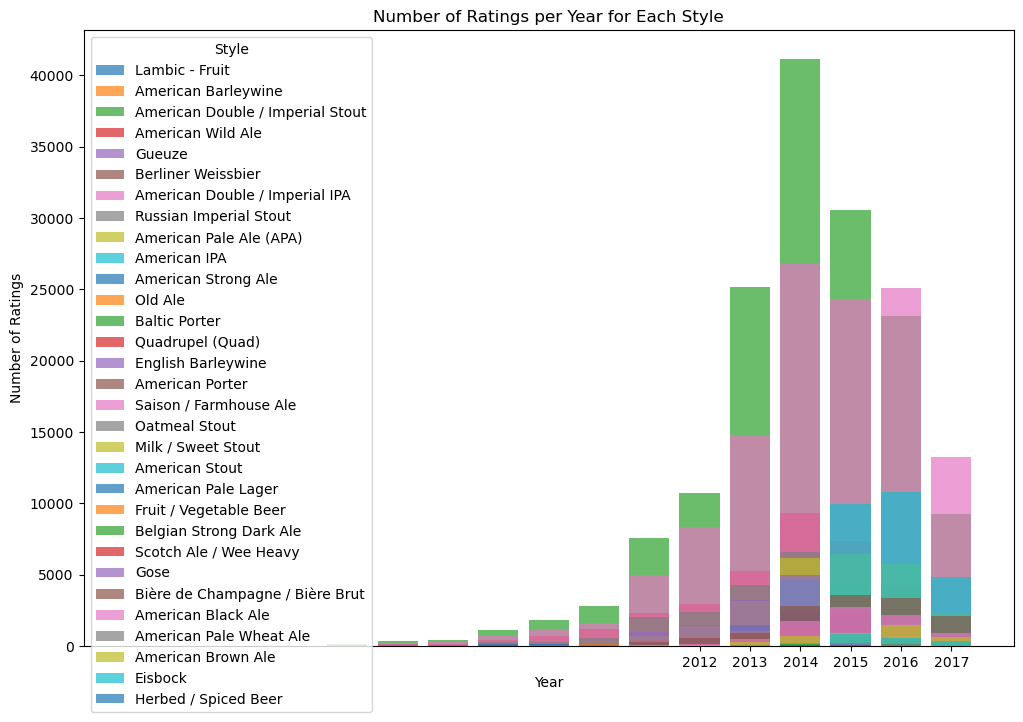

In [21]:
unique_styles = grouped_style["style"].unique()

# Plotting the data as a histogram
plt.figure(figsize=(12, 8))

for style in unique_styles:
    # Extracting the years and corresponding num_ratings for each style
    style_data = grouped_style[grouped_style["style"] == style]["ratings_info"].iloc[0]
    years = list(style_data.keys())
    years_int = [int(year) for year in years]  # Convert years to integers
    nbr_ratings = [style_data[year]['nbr_ratings'] for year in years]

    # Plotting the data as a histogram
    plt.bar(years_int, nbr_ratings, alpha=0.7, label=style)

plt.title('Number of Ratings per Year for Each Style')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.legend(title='Style', loc='upper left')

# Set integer ticks on the x-axis
plt.xticks(years_int)

plt.show()

In [22]:
# Create an empty dictionary to store aggregated values
aggregated_Bstyle = {}

# Iterate over unique beer_ids
for beer_style in ba_style_year_filtered['bigger_style'].unique():
    # Filter rows for the current beer_id
    beer_data = ba_style_year_filtered[ba_style_year_filtered['bigger_style'] == beer_style]
    beer_data = beer_data.sort_values(by='date', ascending=True)
    
    # Initialize a dictionary for dates
    aggregated_Bstyle[beer_style] = {
        'beer_id': beer_data['beer_id'].iloc[0],
        'beer_name': beer_data['beer_name'].iloc[0],  
        'style': beer_data['style'].iloc[0],          
        'bigger_style': beer_data['bigger_style'].iloc[0],
        'nbr_ratings': len(beer_data),
        'avg': beer_data['avg'].iloc[0],
        'ratings_info': {} 
    }

    # Iterate over unique dates
    for date in beer_data['date'].unique():
        date_data = beer_data[beer_data['date'] == date]
        aggregated_Bstyle[beer_style]['ratings_info'][str(date)] = {
            'nbr_ratings': len(date_data),
            'avg': date_data['avg'].iloc[0],
            'locations': {}  
        }

        # Iterate through each location in the current group
        for location, location_group in date_data.groupby('location'):
            aggregated_Bstyle[beer_style]['ratings_info'][str(date)]['locations'][str(location)] = {
                'nbr_ratings': len(location_group),
                'avg': location_group['avg'].iloc[0]
            }

# Convert the dictionary to a DataFrame
grouped_style = pd.DataFrame.from_dict(aggregated_Bstyle, orient='index')

# Sort columns in ascending order
grouped_style = grouped_style.reset_index().drop(columns='index')

grouped_style

,beer_id,beer_name,style,bigger_style,nbr_ratings,avg,ratings_info
0,79976,Not Your Father's Root Beer (19.5%),Herbed / Spiced Beer,Specialty Beers,448,4.64,"{'2012': {'nbr_ratings': 6, 'avg': 4.64, 'loca..."
1,1640,Samuel Adams Millennium,American Strong Ale,Strong Ales,34186,4.62,"{'2001': {'nbr_ratings': 2, 'avg': 4.62, 'loca..."
2,10672,Bourbon County Brand Stout,American Double / Imperial Stout,Stouts,188740,4.50,"{'2003': {'nbr_ratings': 5, 'avg': 4.5, 'locat..."
3,9474,Temptation,American Wild Ale,Wild/Sour Beers,41028,4.41,"{'2003': {'nbr_ratings': 1, 'avg': 4.41, 'loca..."
4,7971,Pliny The Elder,American Double / Imperial IPA,India Pale Ales,153596,4.60,"{'2003': {'nbr_ratings': 1, 'avg': 4.6, 'locat..."
5,64228,Zombie Dust,American Pale Ale (APA),Pale Ales,34224,4.53,"{'2010': {'nbr_ratings': 16, 'avg': 4.53, 'loc..."
6,62761,Maple Bacon Coffee Porter,American Porter,Porters,14250,4.46,"{'2010': {'nbr_ratings': 6, 'avg': 4.46, 'loca..."
7,155067,Triple Dry Hopped Hoponius Union,American Pale Lager,Pale Lagers,90,4.52,"{'2015': {'nbr_ratings': 65, 'avg': 4.52, 'loc..."
8,130409,Blanc De Blancs,Bière de Champagne / Bière Brut,Hybrid Beers,172,4.45,"{'2014': {'nbr_ratings': 81, 'avg': 4.45, 'loc..."
9,213798,Barrel Aged Double Shot Double Black,American Black Ale,Dark Ales,177,4.48,"{'2014': {'nbr_ratings': 9, 'avg': 4.48, 'loca..."


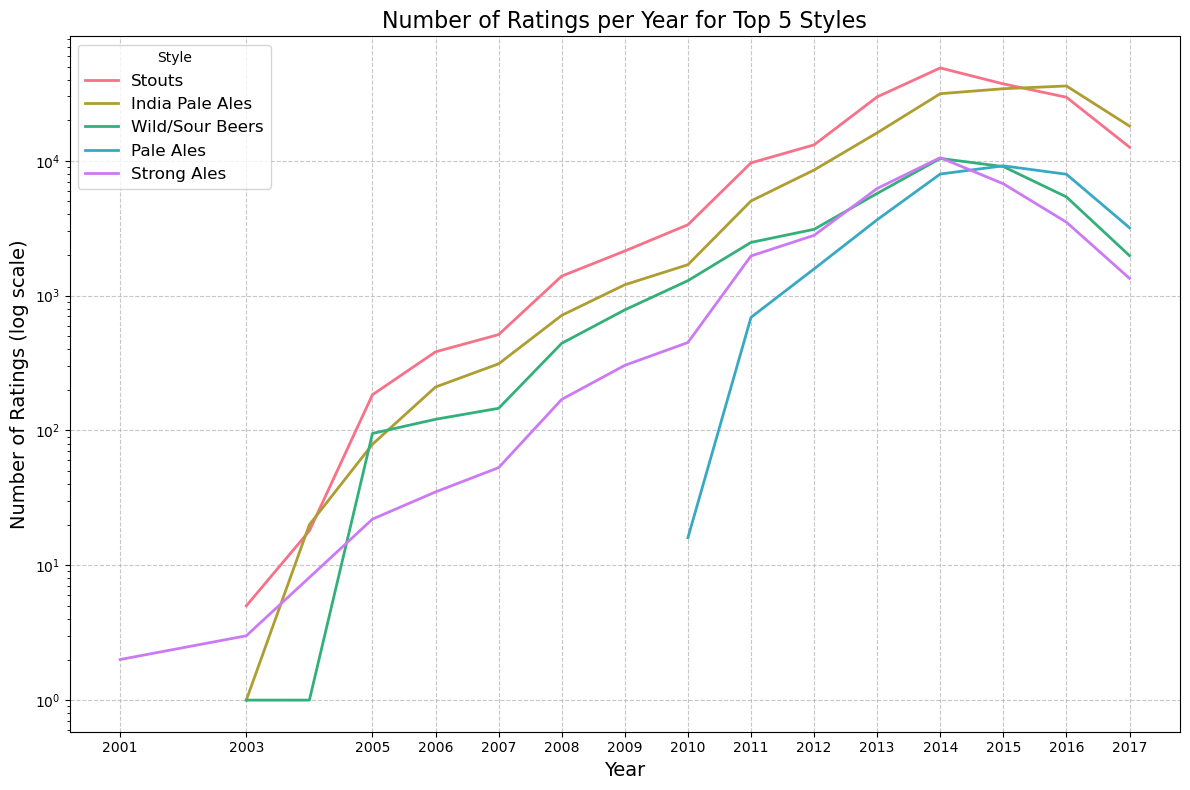

In [23]:
# Calculate the sum of ratings for each style
style_ratings_sum = grouped_style.groupby("bigger_style")["nbr_ratings"].sum()

# Select the top 5 styles with the highest total ratings
top_styles = style_ratings_sum.nlargest(5).index

# Create a stylish line plot for the top 5 styles using seaborn
plt.figure(figsize=(12, 8))

# Set a color palette for better distinction between styles
palette = sns.color_palette("husl", n_colors=len(top_styles))

for style, color in zip(top_styles, palette):
    # Extract information for the current style
    style_data = grouped_style[grouped_style["bigger_style"] == style]["ratings_info"].iloc[0]
    years = list(style_data.keys())
    years_int = [int(year) for year in years]
    nbr_ratings = [style_data[year]['nbr_ratings'] for year in years]

    # Plot the data as a smooth line
    sns.lineplot(x=years_int, y=nbr_ratings, label=style, color=color, linewidth=2)

# Customize plot details
plt.title('Number of Ratings per Year for Top 5 Styles', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Ratings (log scale)', fontsize=14)
plt.yscale('log')
plt.legend(title='Style', loc='upper left', fontsize=12)

# Set integer ticks on the x-axis for better readability
plt.xticks(years_int)

# Display the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
print(grouped_style["ratings_info"][3])

{'2003': {'nbr_ratings': 1, 'avg': 4.41, 'locations': {'United States, California': {'nbr_ratings': 1, 'avg': 4.41}}}, '2004': {'nbr_ratings': 1, 'avg': 4.41, 'locations': {'United States, California': {'nbr_ratings': 1, 'avg': 4.41}}}, '2005': {'nbr_ratings': 95, 'avg': 4.41, 'locations': {'United States, California': {'nbr_ratings': 95, 'avg': 4.41}}}, '2006': {'nbr_ratings': 121, 'avg': 4.41, 'locations': {'United States, California': {'nbr_ratings': 121, 'avg': 4.41}}}, '2007': {'nbr_ratings': 146, 'avg': 4.47, 'locations': {'United States, California': {'nbr_ratings': 146, 'avg': 4.47}}}, '2008': {'nbr_ratings': 443, 'avg': 4.41, 'locations': {'United States, California': {'nbr_ratings': 441, 'avg': 4.41}, 'United States, New York': {'nbr_ratings': 2, 'avg': 4.53}}}, '2009': {'nbr_ratings': 784, 'avg': 4.41, 'locations': {'United States, California': {'nbr_ratings': 770, 'avg': 4.41}, 'United States, Colorado': {'nbr_ratings': 13, 'avg': 4.41}, 'United States, New York': {'nbr_rat

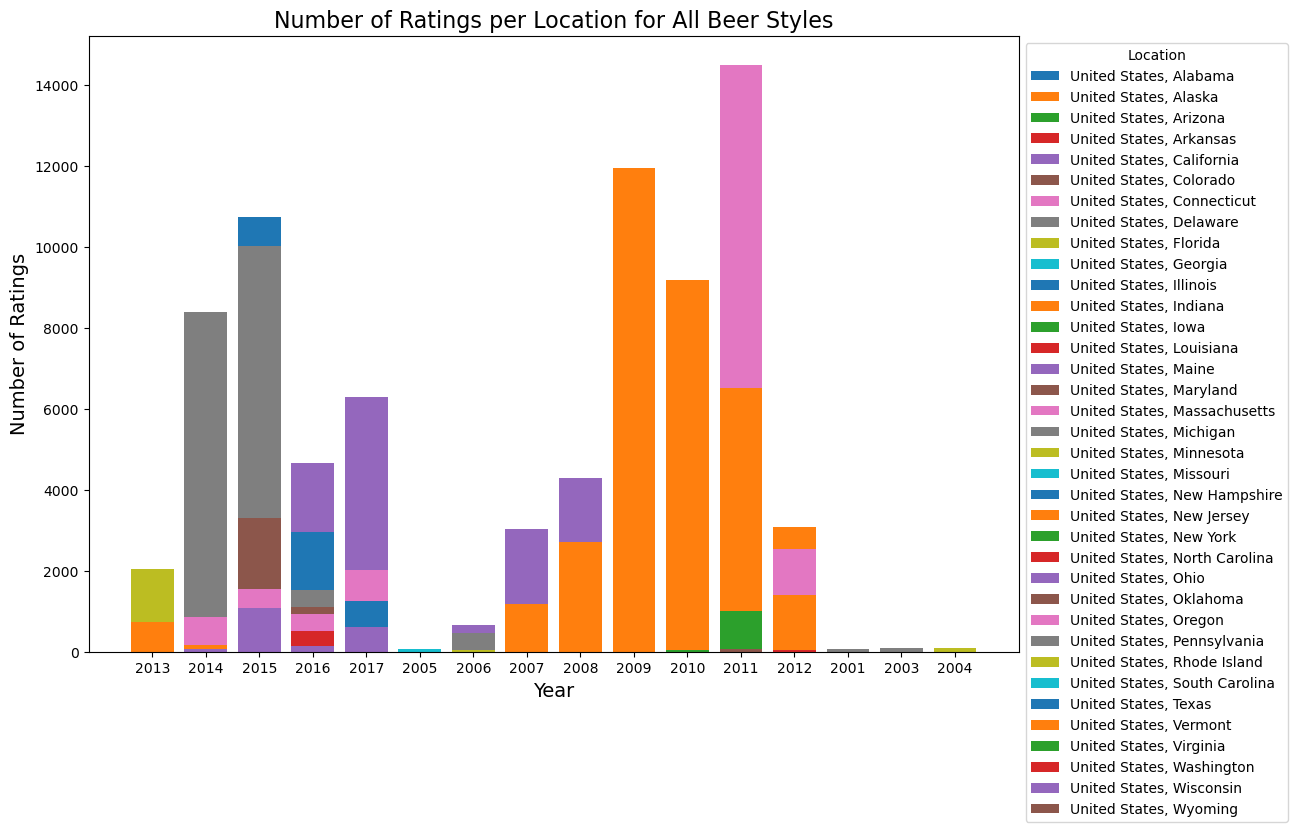

In [36]:
import matplotlib.pyplot as plt

# Prepare data for plotting
all_locations = []
all_ratings_per_location = []
all_years = []

# Iterate over each style of beer
for _, style_group in grouped_style.groupby("bigger_style"):
    for index, row in style_group.iterrows():
        ratings_info = row['ratings_info']

        for year, year_data in ratings_info.items():
            for location, location_data in year_data['locations'].items():
                all_locations.append(location)
                all_ratings_per_location.append(location_data['nbr_ratings'])
                all_years.append(year)

# Create a DataFrame for the combined data
data = {'Location': all_locations, 'Number of Ratings': all_ratings_per_location, 'Year': all_years}
df_combined = pd.DataFrame(data)

# Create a single bar chart for all styles
plt.figure(figsize=(12, 8))
for location, ratings_data in df_combined.groupby('Location'):
    plt.bar(ratings_data['Year'], ratings_data['Number of Ratings'], label=location)

plt.title('Number of Ratings per Location for All Beer Styles', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Ratings', fontsize=14)
plt.legend(title='Location', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

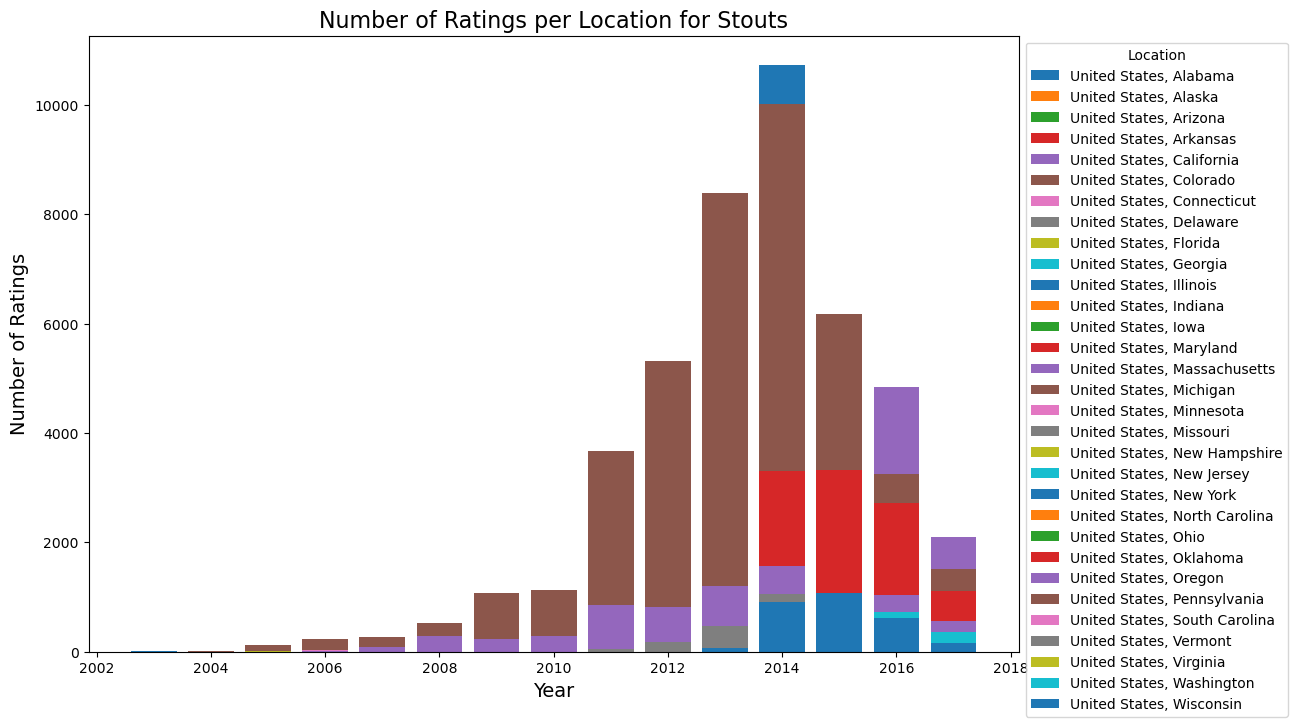

In [41]:
# Select the beer for which you want to plot the graph
selected_beer = "Stouts"  # Replace with the actual beer name

# Find the row corresponding to the selected beer
selected_beer_row = grouped_style[grouped_style["bigger_style"] == selected_beer]

# Check if the beer is found
if not selected_beer_row.empty:
    selected_beer_row = selected_beer_row.iloc[0]
    ratings_info = selected_beer_row['ratings_info']

    # Prepare data for plotting
    locations = []
    ratings_per_location = []
    years = []

    for year, year_data in ratings_info.items():
        for location, location_data in year_data['locations'].items():
            locations.append(location)
            ratings_per_location.append(location_data['nbr_ratings'])
            years.append(year)
            
    # Create a DataFrame for the data
    data = {'Location': locations, 'Number of Ratings': ratings_per_location, 'Year': years}
    df = pd.DataFrame(data)

    # Convert 'Year' column to integers
    df['Year'] = df['Year'].astype(int)

    # Sort the DataFrame by 'Year'
    df = df.sort_values(by='Year')
    # Plot the bar chart
    plt.figure(figsize=(12, 8))
    for location, ratings_data in df.groupby('Location'):
        plt.bar(ratings_data['Year'], ratings_data['Number of Ratings'], label=location)

    plt.title(f'Number of Ratings per Location for {selected_beer}', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Ratings', fontsize=14)
    plt.legend(title='Location', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

else:
    print(f"Beer '{selected_beer}' not found in the dataset.")


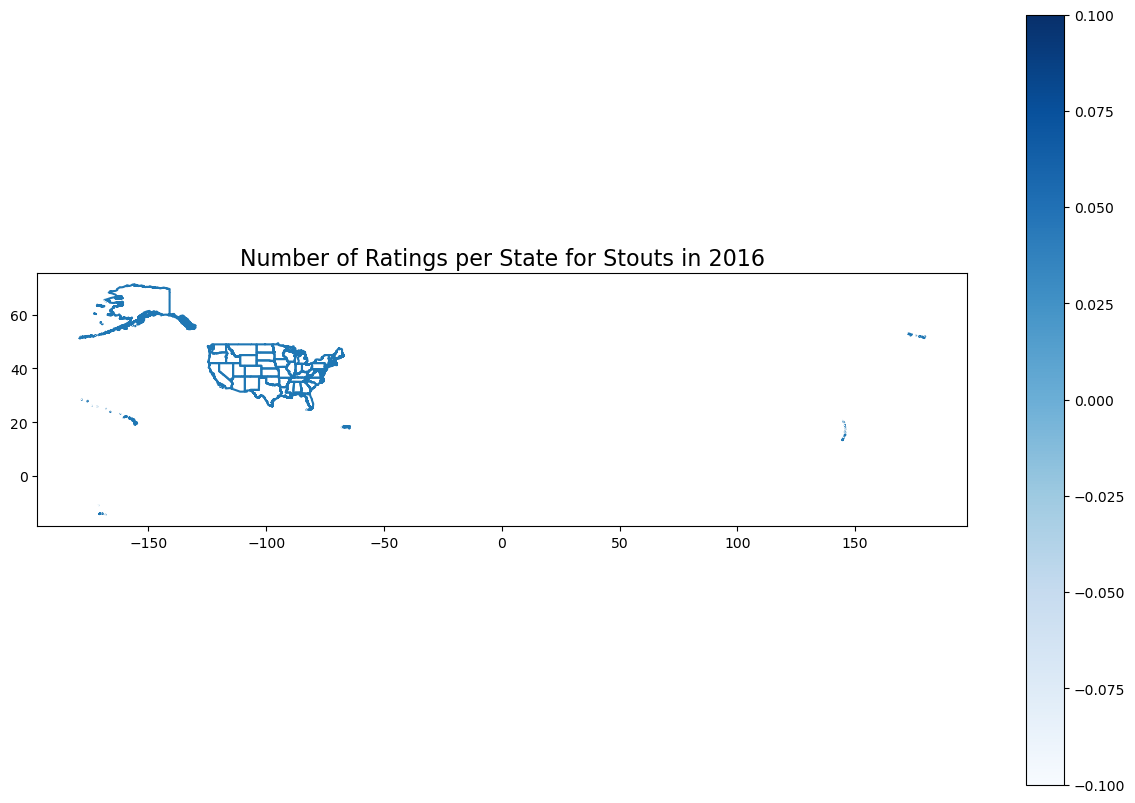

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the U.S. states shapefile
us_states = gpd.read_file('cb_2021_us_state_500k/cb_2021_us_state_500k.shp')

# Select the beer for which you want to plot the graph
selected_beer = "Stouts"  # Replace with the actual beer name

# Find the row corresponding to the selected beer
selected_beer_row = grouped_style[grouped_style["bigger_style"] == selected_beer]

# Check if the beer is found
if not selected_beer_row.empty:
    selected_beer_row = selected_beer_row.iloc[0]
    ratings_info = selected_beer_row['ratings_info']

    # Get ratings for the year 2016
    ratings_2016 = ratings_info.get('2016', {})

    if ratings_2016:
        # Prepare data for plotting
        states = []
        ratings_per_state = []

        for location, location_data in ratings_2016['locations'].items():
            state = location.split(', ')[1]  # Extract state from the location
            states.append(state)
            ratings_per_state.append(location_data['nbr_ratings'])

        # Create a DataFrame for the data
        data = {'State': states, 'Number of Ratings': ratings_per_state}
        df_states = pd.DataFrame(data)

        # Merge with the U.S. states GeoDataFrame to get geometries
        gdf_states = pd.merge(us_states, df_states, how='left', left_on='STUSPS', right_on='State')

        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        gdf_states.boundary.plot(ax=ax)  # Plot state boundaries

        # Plot the choropleth map using the number of ratings
        gdf_states.plot(column='Number of Ratings', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

        plt.title(f'Number of Ratings per State for {selected_beer} in 2016', fontsize=16)
        plt.show()

    else:
        print(f"No ratings data available for {selected_beer} in 2016.")

else:
    print(f"Beer '{selected_beer}' not found in the dataset.")


In [48]:
"""import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import interact

# Load the U.S. states shapefile
us_states = gpd.read_file('cb_2021_us_state_500k/cb_2021_us_state_500k.shp')

# Select the beer for which you want to plot the graph
selected_beer = "Stouts"  # Replace with the actual beer name

# Find the row corresponding to the selected beer
selected_beer_row = grouped_style[grouped_style["bigger_style"] == selected_beer]

# Check if the beer is found
if not selected_beer_row.empty:
    selected_beer_row = selected_beer_row.iloc[0]
    ratings_info = selected_beer_row['ratings_info']

    # Prepare data for plotting
    years_data = []
    for year, year_data in ratings_info.items():
        states = []
        ratings_per_state = []

        for location, location_data in year_data['locations'].items():
            state = location.split(', ')[1]  # Extract state from the location
            states.append(state)
            ratings_per_state.append(location_data['nbr_ratings'])

        # Create a DataFrame for the data
        data = {'State': states, 'Number of Ratings': ratings_per_state, 'Year': [year] * len(states)}
        df_states = pd.DataFrame(data)
        years_data.append(df_states)

    # Concatenate DataFrames for each year
    df_all_years = pd.concat(years_data)

    # Create a plotly figure
    fig = px.choropleth(df_all_years, 
                        geojson=us_states.geometry,
                        locations='State',
                        featureidkey="properties.STUSPS",
                        color='Number of Ratings',
                        animation_frame='Year',
                        color_continuous_scale='Blues',
                        range_color=(0, df_all_years['Number of Ratings'].max()),
                        title=f'Number of Ratings per State for {selected_beer}',
                        labels={'Number of Ratings': 'Number of Ratings'},
                        )

    # Set layout
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(geo=dict(bgcolor='rgba(0,0,0,0)'))

    # Show the figure
    fig.show()

else:
    print(f"Beer '{selected_beer}' not found in the dataset.")

"""

'import geopandas as gpd\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport plotly.express as px\nfrom ipywidgets import interact\n\n# Load the U.S. states shapefile\nus_states = gpd.read_file(\'cb_2021_us_state_500k/cb_2021_us_state_500k.shp\')\n\n# Select the beer for which you want to plot the graph\nselected_beer = "Stouts"  # Replace with the actual beer name\n\n# Find the row corresponding to the selected beer\nselected_beer_row = grouped_style[grouped_style["bigger_style"] == selected_beer]\n\n# Check if the beer is found\nif not selected_beer_row.empty:\n    selected_beer_row = selected_beer_row.iloc[0]\n    ratings_info = selected_beer_row[\'ratings_info\']\n\n    # Prepare data for plotting\n    years_data = []\n    for year, year_data in ratings_info.items():\n        states = []\n        ratings_per_state = []\n\n        for location, location_data in year_data[\'locations\'].items():\n            state = location.split(\', \')[1]  # Extract state from the locati